# Plot cropland soil column per pft for soil moisture related variables

(c) Inne Vanderkelen - October 2023

## 1. Settings

In [69]:
# laod modules 
import xarray as xr
import matplotlib.pyplot as plt
import os
import regionmask 
import pandas as pd
import matplotlib.patheffects as pe
import matplotlib.colors as mcolors


# import own utils module
from iv_utils_daint import *
from ctsm_py.utils import * # info on ctsm utils: https://github.com/NCAR/ctsm_python_gallery 

# do plotting settings
set_plot_param()

# ignore all runtime warnings
warnings.filterwarnings('ignore')

In [70]:
# directory settings

# set directories
outdir = '/scratch/snx3000/ivanderk/'
outdir = '/project/s1207/ivanderk/scratch/'
outdir = '/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/innev/4p1000/'
figdir = '/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/innev/4p1000/Vanderkelen_etal_2025_BG/figures/'
datadir = '/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/innev/4p1000/Vanderkelen_etal_2025_data_topublish/'


# Define directory where processing is done 
procdir =  outdir + 'processing_4p1000/' 

# go to processing directory 
os.chdir(procdir)

# define scenario
scenario = '4p1000'

# case settings
case_ctl = 'IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.CTL.spunup5'
case_scen = 'IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.'+scenario+'.spunup5'

case   = case_ctl
block  = 'lnd' 
stream = 'h1' 


# List of variables to import from file(s) in $indir matching $pattern.
variables = ['H2OSOI',"TOTSOILLIQ","TOTSOILICE", "QINFL" , "QOVER", "QDRAI", 'EFLX_LH_TOT',  "watsat","QROOTSINK" ,"QVEGE", "QVEGT","QSOIL", "watfc", "EFF_POROSITY"] #"SOILPSI", "FPSN","QHR","SMP","GSSHA","GSSUN"


# discard 2004 until 2008 as spin up years
start_year, end_year = 1995, 2014 


time_slice = slice(str(start_year)+"-01-01", str(end_year)+"-12-01")


proj = ccrs.Robinson()



In [71]:
## settings for plotting
ds_ctl =  load_case_ctl(['H2OSOI'])

# get mask and region ids
exclude_ids = np.array([0,1,2,16,28,29,30,31])
mask_regions = regionmask.defined_regions.ar6.land.mask(ds_ctl['H2OSOI'])

region_ids = np.arange(0,44)
region_ids = np.delete(region_ids, exclude_ids)
region_ids_sel = [3,23,37]

regions_sand_clay = [6, 7, 10, 11, 12, 14, 19, 21, 22, 23, 24, 26, 37, 38, 39, 41]

plotting_depth = 1.2 # m 
figsize = (17,38)

labels = ['a.','b.','c.','d.','e.','f.','g.','h.','i.','j.']


# get pfts modelled - bare soil, grassland and crop pfts
pft_list_crops = [15,16]
pft_list_grassland = [0,12,13,14]

In [72]:
# info on soil levels
# manually get soil level info from CLM
levsoi_thickness, levsoi_depth, levgrnd_thickness , levgrnd_depth = get_soildepths()

# get info on soil levels
levsoi = ds_ctl['levsoi'].values
levgrnd = ds_ctl['levgrnd'].values # all soil layers (deepest 5 layers are for thermodynamical calculations)

# input data
# define variables to load from input dataset
input_variables = ['ORGANIC','PFTDATA_MASK','PCT_SAND','PCT_CLAY', 'PCT_CFT', 'PCT_CROP']

# load inputdata
ds_input, ds_input_scen, landmask = load_inputdata(scenario, input_variables, case_ctl)

da_cropland_mask = ds_input['PCT_CROP']>0

## Figure 3: Plot soil moisture

high
(0, 19)
[0.00242723]
 
high
(0, 5)
[0.00373676]
 
high
(5, 19)
[-0.00130953]
 
medium
(0, 19)
[0.00120014]
 
medium
(0, 5)
[0.00189422]
 
medium
(5, 19)
[-0.00069408]
 
4p1000
(0, 19)
[0.00039505]
 
4p1000
(0, 5)
[0.00053689]
 
4p1000
(5, 19)
[-0.00014183]
 


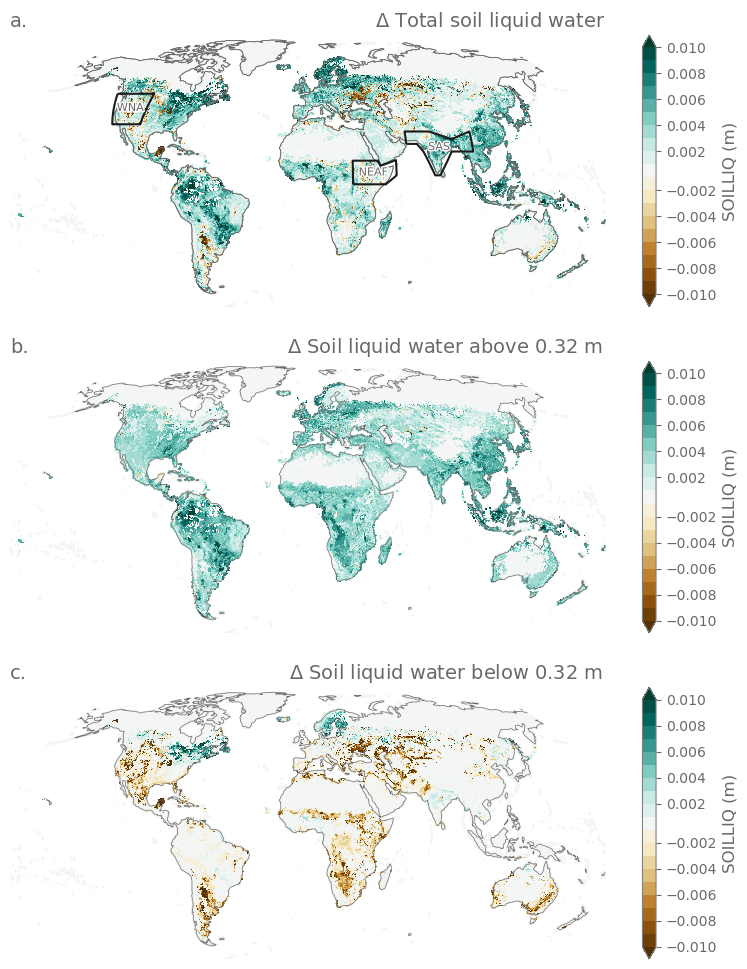

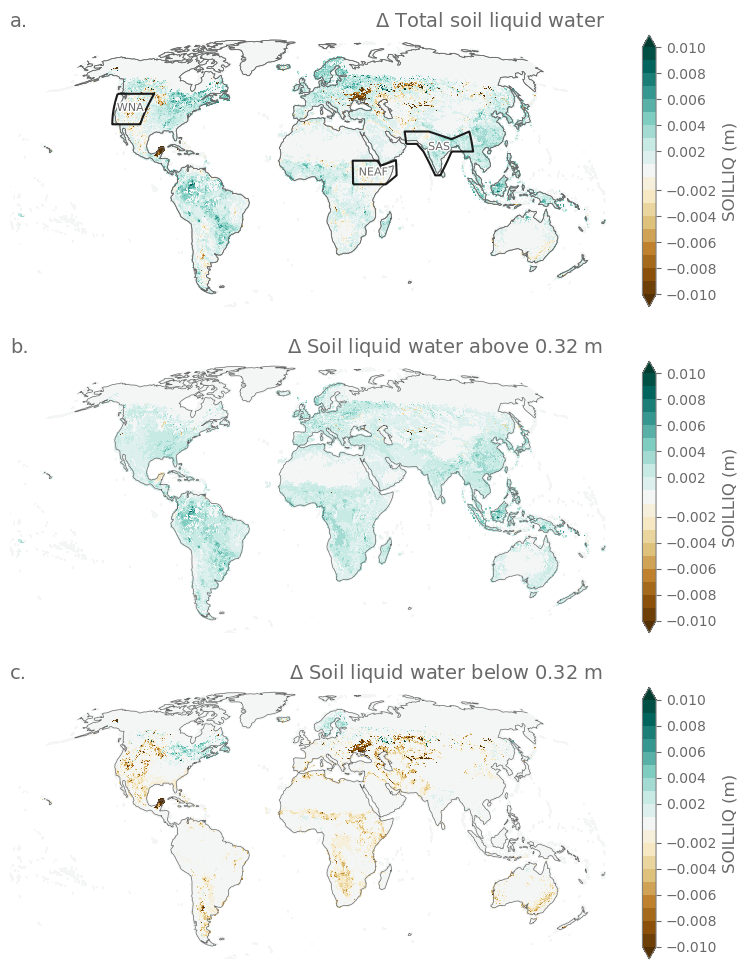

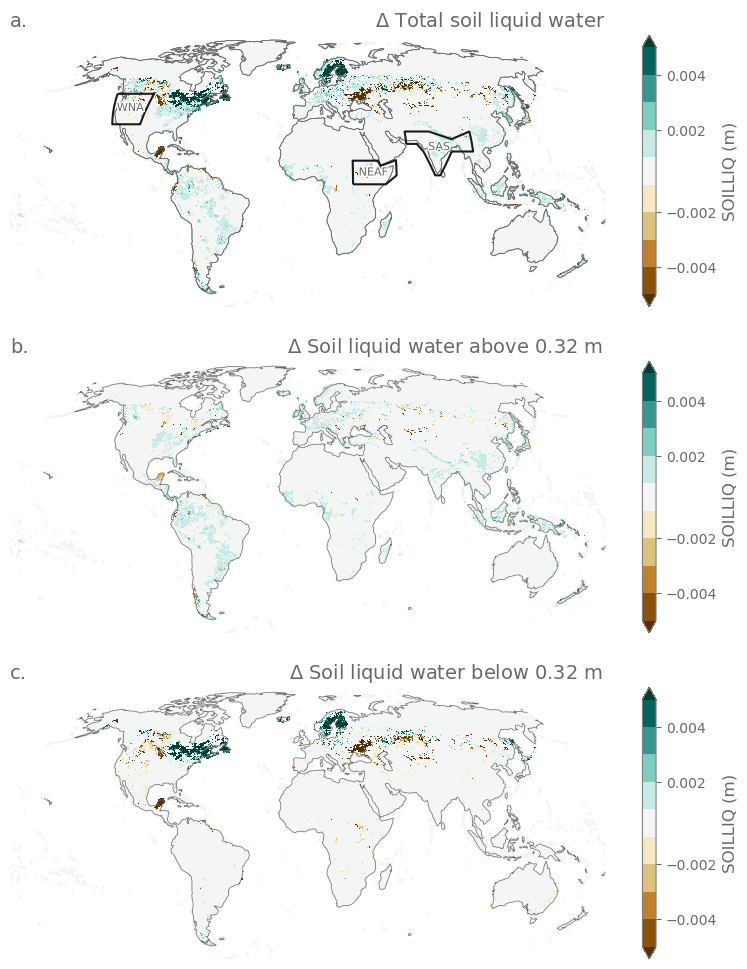

In [77]:
# define scenario
scenarios = ['high', 'medium',  '4p1000']

d_vlims = {'high' : [-1e-2,1e-2], 
           'medium' : [-1e-2,1e-2], 
           '4p1000':  [-0.5e-2,0.5e-2]}
    
case_ctl = 'IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.CTL.spunup5'

for scenario in scenarios: 
    case_scen = 'IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.'+scenario+'.spunup5'

    pft_int = pft_list_crops[0]

    variable = "SOILLIQ" 

    da_pft_ctl  = load_da_gridded_pft(variable, pft_int, case_ctl).rename(variable)
    da_pft_scen = load_da_gridded_pft(variable, pft_int, case_scen).rename(variable)
    da_pft_ctl_conv = conv_hydrol_var(da_pft_ctl.to_dataset(), [variable])[variable]
    da_pft_ctl_conv.attrs['long_name'] = da_pft_ctl.long_name

    da_pft_scen_conv = conv_hydrol_var(da_pft_scen.to_dataset(),[variable])[variable]
    da_pft_scen_conv.attrs['long_name'] = da_pft_scen.long_name

    da_delta = (da_pft_scen_conv - da_pft_ctl_conv)


    ## volumetric soil moisture, aggregating over different layers
    levsoi_selections = [(0,19),  (0,5), (5,19)]
    depths = ['all', 'above32cm', 'below32cm']

    fig, axes = plt.subplots(3,1,figsize=(12,12),subplot_kw={'projection': proj, 'frameon':False})

    vlims = d_vlims[scenario]

    for n, levsoi_sel in enumerate(levsoi_selections): 

        ax = axes[n]
        label = labels[n]
        nstep = 0.001
        da_delta_mean = da_delta.isel(levsoi=range(levsoi_sel[0],levsoi_sel[1])).mean('time').sum('levsoi')
        levels = np.arange(vlims[0],vlims[1]+nstep, nstep)
        levels = np.concatenate((levels[:int((len(levels)-1)/2)], levels[int((len(levels)-1)/2)+1:]))
        ticks = np.arange(-0.01,0.012,0.002)
        ticks = np.delete(ticks,5)
        # limiting values for plotting are given    
        da_delta_mean.where(landmask).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='BrBG', vmin=vlims[0], vmax=vlims[1],  extend='both',  cbar_kwargs={'label': da_delta.name+' (m)', 'fraction': 0.02, 'pad': 0.04, 'ticks' : ticks}, add_labels=False, levels=levels)

        # Overlay the gray mask for non cropland regions
        gray_mask = (da_cropland_mask.where(landmask)==0).astype(int)
        gray_cmap = mcolors.ListedColormap(['none', 'lightgray'])
        gray_norm = mcolors.BoundaryNorm([-0.5, 0.5, 1.5], gray_cmap.N)
        gray_mask.plot( ax=ax, cmap=gray_cmap, norm=gray_norm, add_colorbar=False )

        if n == 0 : 
            ax.set_title('$\Delta$ Total soil liquid water', loc='right')
        elif n == 1:
            ax.set_title('$\Delta$ Soil liquid water above '+str(levsoi_depth[levsoi_sel[1]-1])+' m ', loc='right')

        elif n == 2: 
            ax.set_title('$\Delta$ Soil liquid water below '+str(levsoi_depth[levsoi_sel[0]-1])+' m ', loc='right')
        
        ax.coastlines(color='dimgray', linewidth=0.5)
        ax.set_title(label, loc='left')

        # exclude Antactica from plot
        ax.set_extent([-180,180,-63,90], crs=ccrs.PlateCarree())
        ax.axis('off')

        if n ==0:    
            text_kws = dict(bbox=dict(color="none"),path_effects=[pe.withStroke(linewidth=2, foreground="w")], color="dimgray",fontsize=8)
            regionmask.defined_regions.ar6.land[region_ids_sel].plot(ax=ax, projection=proj,text_kws=text_kws, add_ocean=False, label="abbrev");

        # saving
        da_delta_mean.where(landmask).drop_vars(['ivt_str']).to_dataset(name=da_delta_mean.name).to_netcdf(datadir+'delta_soil_water_'+scenario+'-CTL_'+depths[n]+'.nc')


        print(scenario)
        print(levsoi_sel)
        print(da_delta_mean.where(da_cropland_mask).mean(dim=('lat','lon')).values)
        print(" ")

    fig.savefig(figdir+'soil_water_'+scenario+'.png', bbox_inches='tight')

## Fig. 8: Comparison between scenarios

In [ ]:
levsoi_sel_text= ['Total', 'Above '+str(levsoi_depth[levsoi_sel[0]-1])+' m','Below '+str(levsoi_depth[levsoi_sel[0]-1])+' m']

scenarios = ['high','medium',  '4p1000']
d_scenarios ={}
for k, scenario in enumerate(scenarios): 
    print(scenario)
    # load simulations and calculate delta
    case_scen = 'IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.'+scenario+'.spunup5'

    pft_int = pft_list_crops[0]

    variable = "SOILLIQ" 

    da_pft_ctl = load_da_gridded_pft(variable, pft_int, case_ctl).rename(variable)
    da_pft_scen = load_da_gridded_pft(variable, pft_int, case_scen).rename(variable)
    da_pft_ctl_conv = conv_hydrol_var(da_pft_ctl.to_dataset(), [variable])[variable]
    da_pft_ctl_conv.attrs['long_name'] = da_pft_ctl.long_name

    da_pft_scen_conv = conv_hydrol_var(da_pft_scen.to_dataset(),[variable])[variable]
    da_pft_scen_conv.attrs['long_name'] = da_pft_scen.long_name

    da_delta = (da_pft_scen_conv - da_pft_ctl_conv)


    d_region = {}            
    for i,region in enumerate(region_ids_sel):

        d_level_list = {}

        ## volumetric soil moisture, aggregating over different layers
        for n, levsoi_sel in enumerate(levsoi_selections): 
            da_delta_mean = da_delta.isel(levsoi=range(levsoi_sel[0],levsoi_sel[1])).mean('time').sum('levsoi')
            da_ctl_mean = da_pft_ctl_conv.isel(levsoi=range(levsoi_sel[0],levsoi_sel[1])).mean('time').sum('levsoi')
            mask = regionmask.defined_regions.ar6.land.mask(da_delta_mean)
            
 
            da_delta_mean_region = da_delta_mean.where(mask==region).mean(dim=('lat','lon')) #/  da_ctl_mean.where(mask==region).mean(dim=('lat','lon')) *100

            #da_ctl_seasmean_region = (da_delta_timmean.sel(pft=pft_int).where(mask==region).mean(dim=('lat','lon')) / da_ctl_timmean.sel(pft=pft_int).where(mask==region).mean(dim=('lat','lon'))).values*100

            d_level_list[n] = float(da_delta_mean_region.values)

        d_region[str(region)] = pd.Series(d_level_list).to_frame(name=str(scenario))
        
    d_scenarios[scenario] = d_region

keys = map(str, region_ids_sel) 
d_regions = {key:{k:d_scenarios[k][key] for k in d_scenarios if key in d_scenarios[k]} for key in keys}

high
medium
4p1000


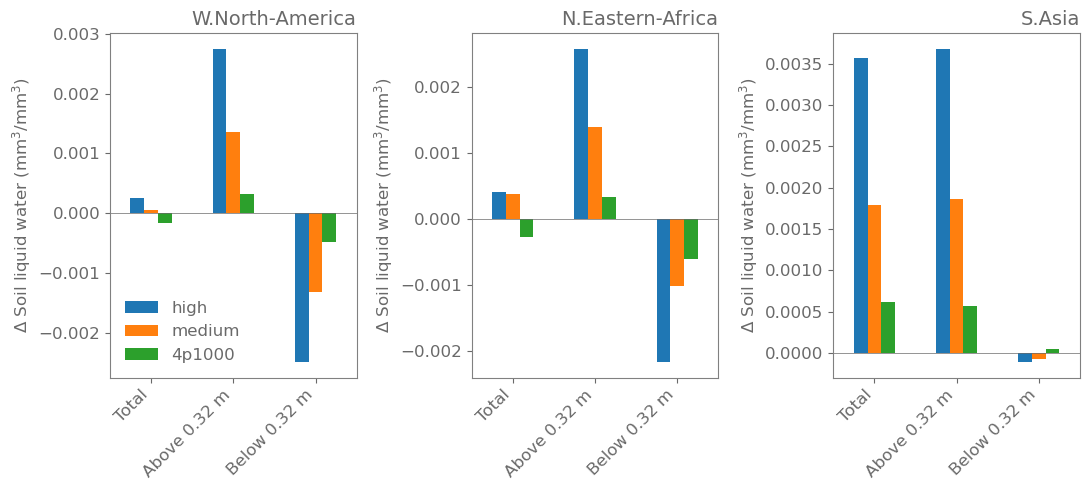

In [ ]:
figsize = (11,5)

fig, axes = plt.subplots(1,len(region_ids_sel),figsize=figsize)
axes = axes.flatten()

#x = np.arange(1,len(variables_wb_toplot)+1,1)

for i,region in enumerate(region_ids_sel):
    
    region_name = regionmask.defined_regions.ar6.land[region].name
    region_abbrev = regionmask.defined_regions.ar6.land[region].abbrev
    df  =  pd.concat([v for k,v in d_regions[str(region)].items()],axis=1)
    ax = axes[i]
    
    if i == 0: 
        df.plot.bar(ax=ax)
    else: 
        df.plot.bar(ax=ax, legend = False)
        
    ax.set_title(region_name,loc='right')
    ax.axhline(y=0, color='dimgray', linewidth=0.5)
    #ax.axvline(x=0.5, color='dimgray', linewidth=1, linestyle = 'dotted')
    #ax.axvline(x=1.5, color='dimgray', linewidth=1, linestyle = 'dotted')
    #ax.axvline(x=4.5, color='dimgray', linewidth=1, linestyle = 'dotted')

    ax.set_ylabel('$\Delta$ Soil liquid water (mm$^3$/mm$^3$)')

    ax.set_xticks(range(0,3),levsoi_sel_text ,rotation=45, ha='right')
    if i==0:
        ax.legend(frameon=False)

fig.tight_layout()
fig.savefig(figdir+'region_barplots_scenarios.png',bbox_inches='tight')

## Plot maps of waterbalance terms

In [ ]:
# difference 
d_vlims_high = {"QDRAI"         : [-10,10], 
           "QINFL"         : [-1000,1000],
           "QOVER"         :  [-10,10],
           "TOTSOILLIQ"    :  [-2e-2,2e-2],
           "EFLX_LH_TOT"   :  [-20,20],
           "QVEGT"         :  [-10,10], 
           "QVEGE"         :  [-10,10], 
           "QSOIL"         :  [-10,10],
           "ET_TOT"        : [-10,10],
           "SOILWATER_10CM": [-4,4]}

# to adjust! 
d_vlims_medium = {"QDRAI"         : [-10,10], 
           "QINFL"         : [-1000,1000],
           "QOVER"         :  [-10,10],
           "TOTSOILLIQ"    :  [-2e-2,2e-2],
           "EFLX_LH_TOT"   :  [-2e-2,2e-2],
           "QVEGT"         :  [-5,5], 
           "QVEGE"         : [-5,5], 
           "QSOIL"         :  [-5,5], 
           "ET_TOT"        : [-5,5],
           "SOILWATER_10CM": [-4,4]}

d_vlims_4p1000 = {"QDRAI"         : [-1,1], 
           "QINFL"         : [-100,100],
           "QOVER"         : [-1,1],
           "TOTSOILLIQ"    : [-0.5e-2,0.5e-2],
           "EFLX_LH_TOT"   : [-0.5e-2,0.5e-2],
           "QVEGT"         :  [-2.5,2.5],  
           "QVEGE"         : [-2.5,2.5], 
           "QSOIL"         :  [-2.5,2.5], 
           "ET_TOT"        : [-2.5,2.5],
            "TOTSOILLIQ"         : [-0.5e-2,0.5e-2], }

d_nsteps_scenario = {"high": 0.0025, "4p1000": 0.0005}

d_vlims_scenario = {'high':d_vlims_high, 
                   'medium':d_vlims_medium,
                   '4p1000' :d_vlims_4p1000 }


d_title =  {"QDRAI"         : "$\Delta$ Subsurface drainage" , 
           "QINFL"         : "$\Delta$ infiltration" ,
           "QOVER"         :  "$\Delta$ Surface runoff" ,
           "QVEGT"         : "$\Delta$ Vegetation transpiration" , 
           "QVEGE"         : "$\Delta$ Vegetation evaporation", 
           "QSOIL"         : "$\Delta$ Soil evaporation", 
           "ET_TOT"        : "$\Delta$ Total evapotranspiration",}

## Fig. 5: ET terms 

high
ET_TOT
[0.00181892]
m/year

medium
ET_TOT
[0.00093955]
m/year

4p1000
ET_TOT
[0.00054424]
m/year



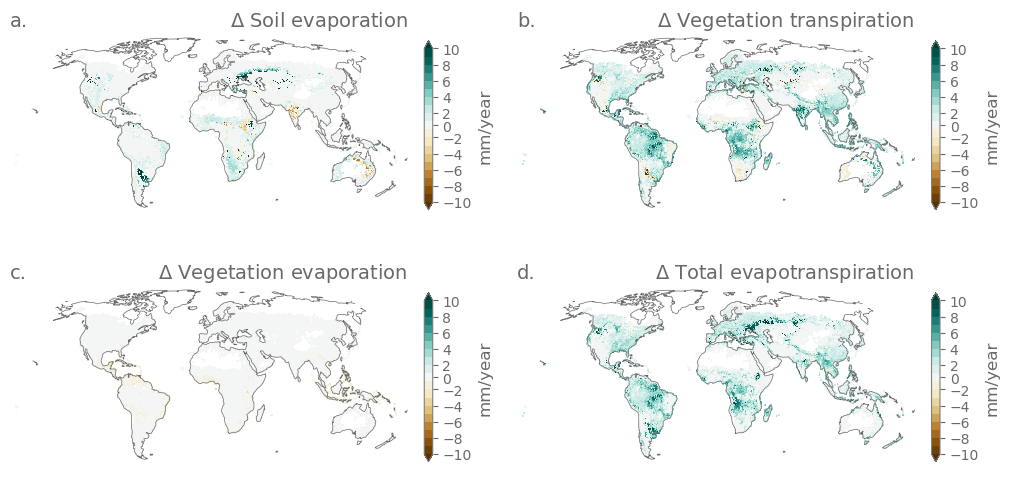

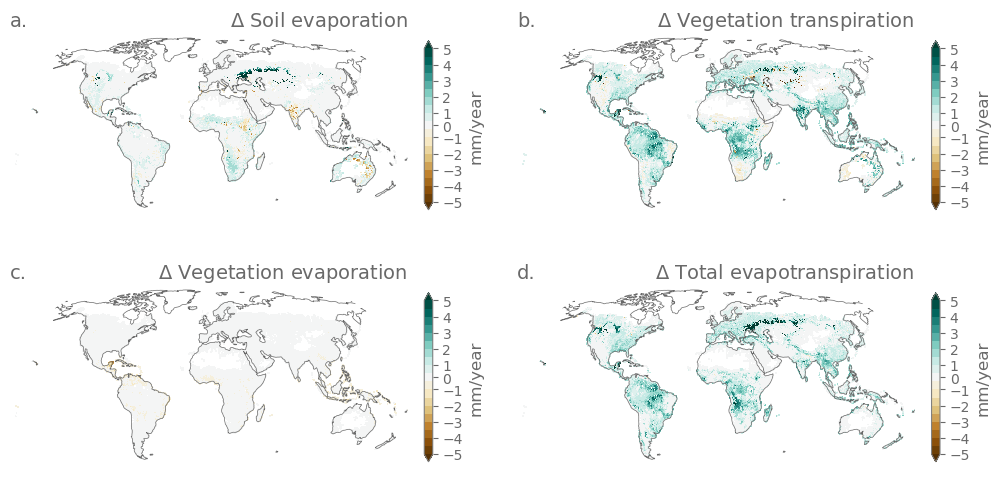

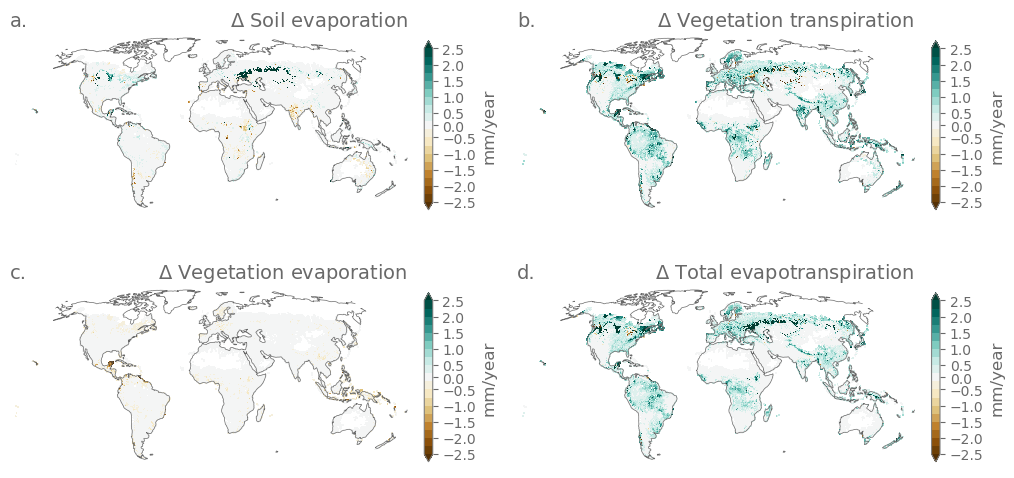

In [85]:
import matplotlib as mpl

mpl.rc('ytick',labelsize=10)


variables_toplot = [ "QSOIL", "QVEGT","QVEGE", "ET_TOT"]
variables_names = ["soil_evaporation", "vegetation_transpiration","vegetation_evaporation", "total_evapotranspiration"]
d_nsteps_scenario = {"high": 0.001, "medium": 0.0005,"4p1000": 0.00025}
d_nsteps_scenario = {"high": 1, "medium": 0.5,"4p1000": 0.25}

scenarios = ['high','medium',  '4p1000']
# define scenario
for scenario in scenarios:


    case_scen = 'IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.'+scenario+'.spunup5'

    pft_int = pft_list_crops[0]
    # make plot with all WB terms
    fig, axes = plt.subplots(2,2,figsize=(12,6),subplot_kw={'projection': proj, 'frameon':False})
    axes = axes.flatten()

    cmap='BrBG'


    for i, variable in enumerate(variables_toplot):

        if variable == "ET_TOT":

            list_ctl = []
            list_scen = []

            for variable_interm in ["QSOIL", "QVEGT","QVEGE"]:
                da_ctl  = load_da_gridded_pft(variable_interm, pft_int, case_ctl).rename(variable)
                da_scen = da_pft_scen = load_da_gridded_pft(variable_interm, pft_int, case_scen).rename(variable)
                list_ctl.append(da_ctl)
                list_scen.append(da_scen)
            da_pft_ctl = sum(list_ctl).rename(variable)
            da_pft_scen = sum(list_scen).rename(variable)
            da_pft_ctl.attrs['long_name'] = 'Total evapotranspiration'
            da_pft_scen.attrs['long_name'] = 'Total evapotranspiration'
            da_pft_ctl.attrs['units'] = da_ctl.attrs['units']
            da_pft_scen.attrs['units'] = da_scen.attrs['units']


        else: 
            da_pft_ctl = load_da_gridded_pft(variable, pft_int, case_ctl).rename(variable)

            da_pft_scen = load_da_gridded_pft(variable, pft_int, case_scen).rename(variable)

        da_pft_ctl_conv = conv_hydrol_var(da_pft_ctl.to_dataset(), [variable])[variable]
        da_pft_ctl_conv.attrs['long_name'] = da_pft_ctl.long_name

        da_pft_scen_conv = conv_hydrol_var(da_pft_scen.to_dataset(),[variable])[variable]
        da_pft_scen_conv.attrs['long_name'] = da_pft_scen.long_name


        da_delta = (da_pft_scen_conv - da_pft_ctl_conv)


        ax = axes[i]

        label = labels[i]

        vlims = d_vlims_scenario[scenario][variable]
        nstep= d_nsteps_scenario[scenario]
        levels = np.arange(vlims[0],vlims[1]+nstep, nstep)
        levels = np.concatenate((levels[:int((len(levels)-1)/2)], levels[int((len(levels)-1)/2)+1:]))

        nstep_ticks = nstep*2
        ticks = np.arange(vlims[0],vlims[1]+nstep_ticks, nstep_ticks)
        # calc delta
        if variable in d_vlims_scenario[scenario].keys(): 
            if 'levsoi' in da_delta.dims: 
                da_delta = da_delta.weighted(da_delta['levsoi']).mean(dim='levsoi')
            elif 'levgrnd' in da_delta.dims: 

                da_delta = da_delta.weighted(da_delta['levgrnd']).mean(dim='levgrnd')

            da_delta.attrs = da_pft_ctl_conv.attrs

        # plot
        (da_delta*10**3).mean('time').plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, vmin=vlims[0], vmax=vlims[1], extend='both',  cbar_kwargs={'label': 'mm/year', 'fraction': 0.02, 'pad': 0.04, 'ticks':ticks, }, levels=levels, add_labels=False)

        if variable == "ET_TOT":
            print(scenario)
            print(da_delta.name)
            print(da_delta.where(da_cropland_mask).mean(dim=('lat','lon')).mean('time').values)
            print("m/year")
            print("")

        ax.set_title(d_title[variable], loc='right')
        ax.set_title(label, loc='left')

        ax.coastlines(color='dimgray', linewidth=0.5)
        # exclude Antactica from plot
        ax.set_extent([-180,180,-63,90], crs=ccrs.PlateCarree())
        ax.axis('off')

        # save
        (da_delta).mean('time').drop_vars(['ivt_str']).to_dataset(name=da_delta.name).to_netcdf(datadir+'delta_'+variables_names[i]+'_'+scenario+'-CTL.nc')


    fig.tight_layout()
    fig.savefig(figdir+'wbterms_ET_'+scenario+'_new.png', bbox_inches='tight')

## Fig. 7 runoff

high
QOVER
[-0.0012202]
m/year

high
QDRAI
[-0.00058642]
m/year

medium
QOVER
[-0.00066828]
m/year

medium
QDRAI
[-0.0002631]
m/year

4p1000
QOVER
[-0.00079401]
m/year

4p1000
QDRAI
[0.00025494]
m/year



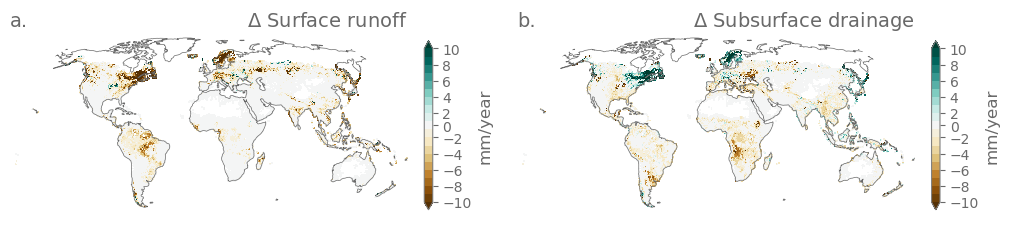

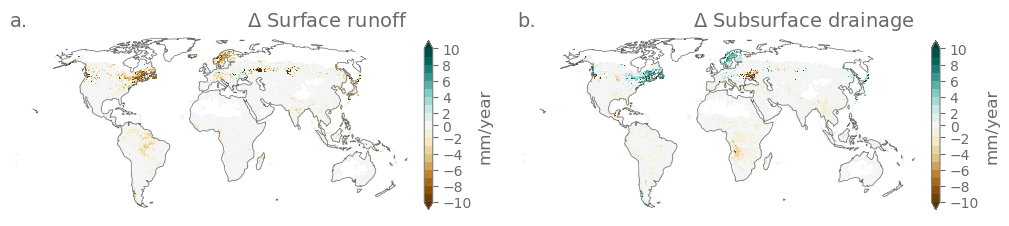

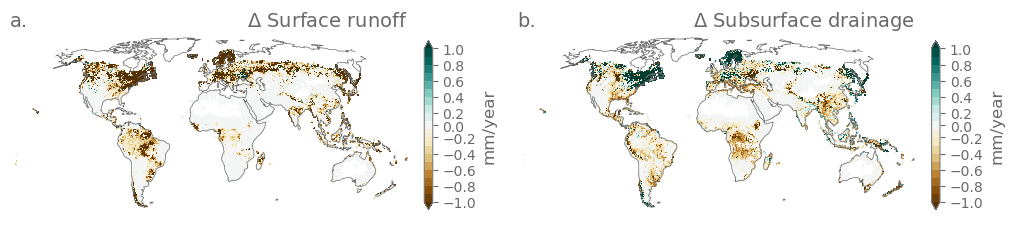

In [84]:
import matplotlib as mpl

mpl.rc('ytick',labelsize=10)

variables_toplot = ["QOVER", "QDRAI"]
variables_names = ["surface_runoff", "subsurface_drainage"]
                    #,  "QINFL"]
d_nsteps_scenario = {"high": 1, "medium": 1,"4p1000": 0.1}

scenarios = ['high','medium',  '4p1000']
# define scenario
for scenario in scenarios: 
    

    case_scen = 'IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.'+scenario+'.spunup5'

    pft_int = pft_list_crops[0]
    # make plot with all WB terms
    fig, axes = plt.subplots(1,2,figsize=(12,10),subplot_kw={'projection': proj, 'frameon':False})
    axes = axes.flatten()

    cmap='BrBG'

    for i, variable in enumerate(variables_toplot): 

        da_pft_ctl = load_da_gridded_pft(variable, pft_int, case_ctl).rename(variable)

        da_pft_scen = load_da_gridded_pft(variable, pft_int, case_scen).rename(variable)

        da_pft_ctl_conv = conv_hydrol_var(da_pft_ctl.to_dataset(), [variable])[variable]
        da_pft_ctl_conv.attrs['long_name'] = da_pft_ctl.long_name

        da_pft_scen_conv = conv_hydrol_var(da_pft_scen.to_dataset(),[variable])[variable]
        da_pft_scen_conv.attrs['long_name'] = da_pft_scen.long_name


        da_delta = (da_pft_scen_conv - da_pft_ctl_conv)

        ax = axes[i]

        label = labels[i]

        vlims = d_vlims_scenario[scenario][variable]
        nstep= d_nsteps_scenario[scenario]
        levels = np.arange(vlims[0],vlims[1]+nstep, nstep)
        levels = np.concatenate((levels[:int((len(levels)-1)/2)], levels[int((len(levels)-1)/2)+1:]))

        nstep_ticks = nstep*2
        ticks = np.arange(vlims[0],vlims[1]+nstep_ticks, nstep_ticks)
        # calc delta
        if variable in d_vlims_scenario[scenario].keys(): 
            if 'levsoi' in da_delta.dims: 
                da_delta = da_delta.weighted(da_delta['levsoi']).mean(dim='levsoi')
            elif 'levgrnd' in da_delta.dims: 

                da_delta = da_delta.weighted(da_delta['levgrnd']).mean(dim='levgrnd')

            da_delta.attrs = da_pft_ctl_conv.attrs

        # plot
        (da_delta*10**3).mean('time').plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, vmin=vlims[0], vmax=vlims[1], extend='both',  cbar_kwargs={'label': 'mm/year', 'fraction': 0.02, 'pad': 0.04, 'ticks':ticks}, levels=levels, add_labels=False)

        ax.set_title(d_title[variable], loc='right')
        ax.set_title(label, loc='left')

        ax.coastlines(color='dimgray', linewidth=0.5)
        # exclude Antactica from plot
        ax.set_extent([-180,180,-63,90], crs=ccrs.PlateCarree())

        ax.axis('off')

        # save
        (da_delta).mean('time').drop_vars(['ivt_str']).to_dataset(name=da_delta.name).to_netcdf(datadir+'delta_'+variables_names[i]+'_'+scenario+'-CTL.nc')

        print(scenario)
        print(da_delta.name)
        print(da_delta.where(da_cropland_mask).mean(dim=('lat','lon')).mean('time').values)
        print("m/year")
        print("")

    fig.tight_layout()
    fig.savefig(figdir+'wbterms_hydrology_'+scenario+'.png', bbox_inches='tight')

## Appendix figure infiltration

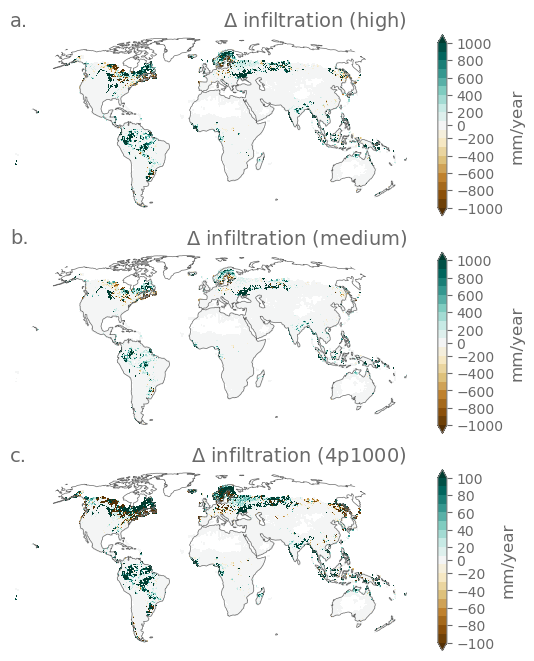

In [79]:
variable = "QINFL"
variable_name = "infiltration"

scenarios = ['high','medium',  '4p1000']
# define scenario
d_nsteps_scenario = {"high": 100, "medium": 100,"4p1000": 10}




pft_int = pft_list_crops[0]
# make plot with all WB terms
fig, axes = plt.subplots(len(scenarios),1,figsize=(10,8),subplot_kw={'projection': proj, 'frameon':False})
axes = axes.flatten()

cmap='BrBG'


for i, scenario in enumerate(scenarios): 
    case_scen = 'IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.'+scenario+'.spunup5'

    da_pft_ctl = load_da_gridded_pft(variable, pft_int, case_ctl).rename(variable)

    da_pft_scen = load_da_gridded_pft(variable, pft_int, case_scen).rename(variable)

    da_pft_ctl_conv = conv_hydrol_var(da_pft_ctl.to_dataset(), [variable])[variable]
    da_pft_ctl_conv.attrs['long_name'] = da_pft_ctl.long_name

    da_pft_scen_conv = conv_hydrol_var(da_pft_scen.to_dataset(),[variable])[variable]
    da_pft_scen_conv.attrs['long_name'] = da_pft_scen.long_name


    da_delta = (da_pft_scen_conv - da_pft_ctl_conv)

    ax = axes[i]

    label = labels[i]

    vlims = d_vlims_scenario[scenario][variable]
    nstep= d_nsteps_scenario[scenario]
    levels = np.arange(vlims[0],vlims[1]+nstep, nstep)
    levels = np.concatenate((levels[:int((len(levels)-1)/2)], levels[int((len(levels)-1)/2)+1:]))

    nstep_ticks = nstep*2
    ticks = np.arange(vlims[0],vlims[1]+nstep_ticks, nstep_ticks)
    # calc delta
    if variable in d_vlims_scenario[scenario].keys(): 
        if 'levsoi' in da_delta.dims: 
            da_delta = da_delta.weighted(da_delta['levsoi']).mean(dim='levsoi')
        elif 'levgrnd' in da_delta.dims: 

            da_delta = da_delta.weighted(da_delta['levgrnd']).mean(dim='levgrnd')

        da_delta.attrs = da_pft_ctl_conv.attrs

    # plot
    (da_delta*10**3).mean('time').plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, vmin=vlims[0], vmax=vlims[1], extend='both',  cbar_kwargs={'label': 'mm/year', 'fraction': 0.02, 'pad': 0.04, 'ticks':ticks}, levels=levels, add_labels=False)

    ax.set_title(d_title[variable] +' ('+scenario+')', loc='right')
    ax.set_title(label, loc='left')

    ax.coastlines(color='dimgray', linewidth=0.5)
    # exclude Antactica from plot
    ax.set_extent([-180,180,-63,90], crs=ccrs.PlateCarree())
 
    ax.axis('off')

        # save
    (da_delta).mean('time').drop_vars(['ivt_str']).to_dataset(name=da_delta.name).to_netcdf(datadir+'delta_'+variable_name+'_'+scenario+'-CTL.nc')


fig.tight_layout()
fig.savefig(figdir+'wbterms_infl_scenarios.png', bbox_inches='tight')

## Fig. 4: Soil moisture in seasonal profiles

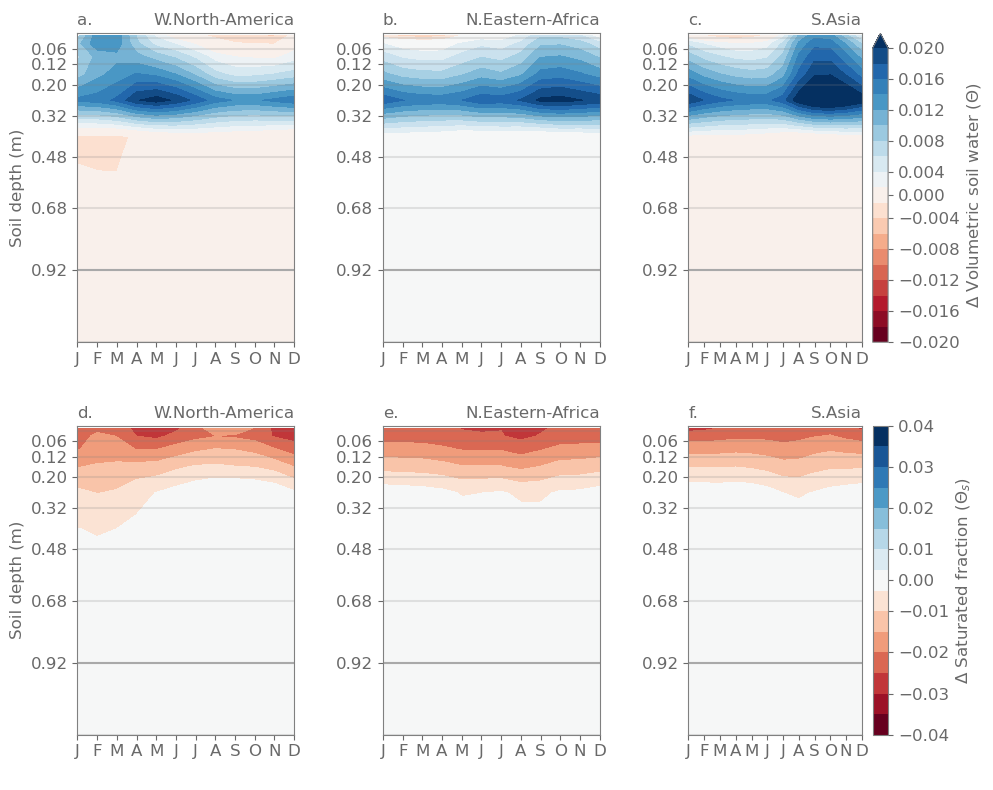

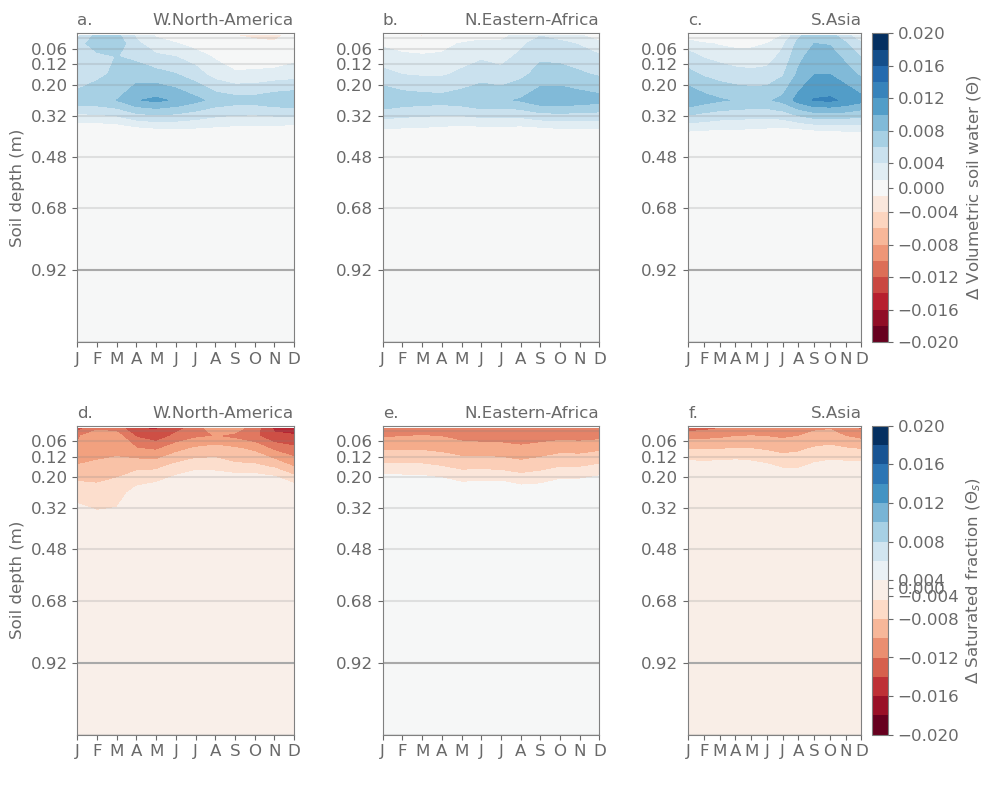

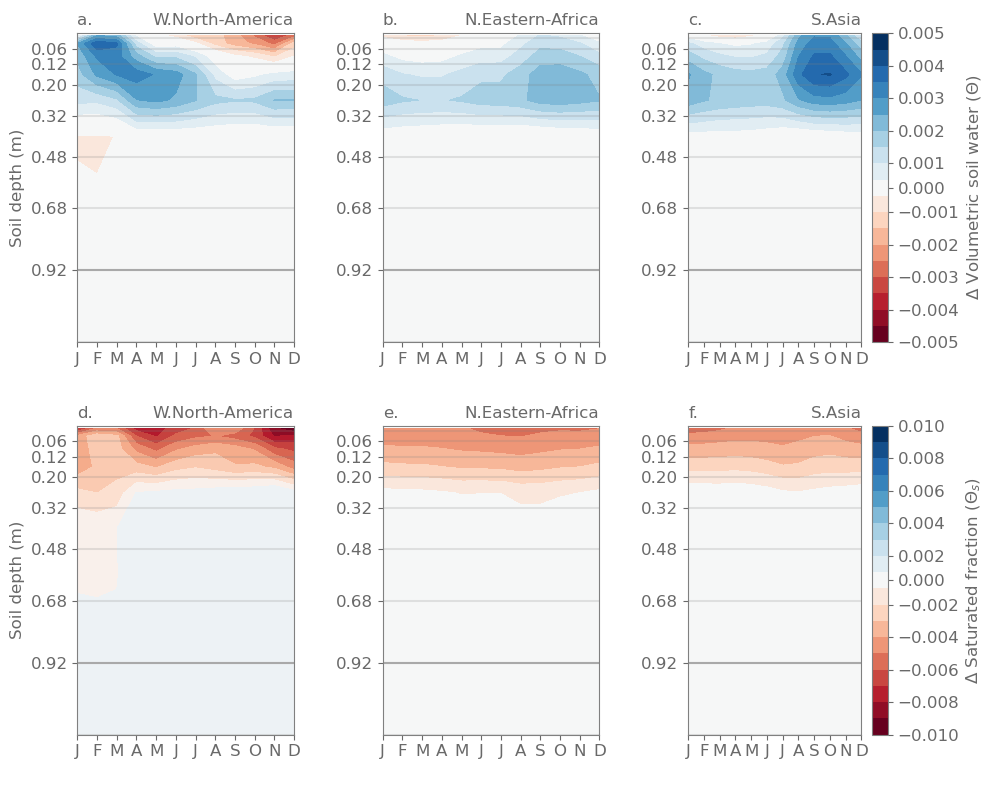

In [81]:
import matplotlib as mpl

mpl.rc('ytick',labelsize=12)
flag_calc_regionmeans = False

scenarios = ['high', 'medium', '4p1000']

# define scenario
for scenario in scenarios: 
    
    case_scen = 'IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.'+scenario+'.spunup5'
    
    # crop list
    pft_list = [pft_list_crops[0]]


    if flag_calc_regionmeans: 
        save_regionalmean_delta_and_delta_rel('H2OSOI', pft_list, case_ctl, case_scen, region_ids, mask_regions, scenario)
        save_regionalmean_delta_and_delta_rel('satfrac', pft_list, case_ctl, case_scen, region_ids, mask_regions, scenario)

    # do plotting
    pft_int = pft_list_crops[0]

    # prepare for plotting 
    variable = 'H2OSOI'
    # open regions dataset
    da_regions = xr.open_dataset(procdir+'/postprocessing/pft_gridding/regional_means.'+variable+'.'+str(pft_int)+'.'+scenario+'.delta_change.nc')[variable]

    da_regions_seasmean = da_regions.groupby('time.month').mean().squeeze()


    figsize = (10,8)
    fig, axes = plt.subplots(2,3,figsize=figsize)
    axes = axes.flatten()

    for i, region in enumerate(region_ids_sel):

        ax = axes[i]

        region_name = regionmask.defined_regions.ar6.land[region].name
        region_abbrev = regionmask.defined_regions.ar6.land[region].abbrev
        if scenario == 'high':  
            levels = np.arange(-0.02,0.022,0.002)
            ticks  = np.arange(-0.02,0.022,0.004)
        elif scenario == 'medium':  
            levels = np.arange(-0.02,0.022,0.002)
            ticks  = np.arange(-0.02,0.022,0.004)
        elif scenario =='4p1000': 
            levels = np.arange(-0.005,0.0055,0.0005)
            ticks  = np.arange(-0.005,0.0055,0.001)

        levels = np.concatenate((levels[:int((len(levels)-1)/2)], levels[int((len(levels)-1)/2)+1:]))

            # with colorbar
        if i == len(region_ids_sel)-1: 
            da_regions_seasmean.sel(region=region).plot.contourf(ax=ax, x='month', y='levsoi', cmap='RdBu', cbar_kwargs={'label':'$\Delta$ Volumetric soil water ($\Theta$)', 'ticks':ticks}, levels= levels)
        # without colorbar
        else: 
            da_regions_seasmean.sel(region=region).plot.contourf(ax=ax, x='month', y='levsoi', cmap='RdBu', levels= levels, add_colorbar=False)

        ax.hlines(levsoi_depth, 1,12, color='grey', alpha=0.2)
        ax.hlines(levsoi_depth[7],1,12, color='darkgrey', alpha=1)

        ax.set_yticks(np.array(levsoi_depth)[np.array(levsoi_depth) < plotting_depth][1:])
        ax.set_ylim([plotting_depth,0])
        ax.set_title(region_name, loc='right', size=12)
        ax.set_title(' ', loc='center')
        ax.set_title(labels[i], loc='left', size=12)
        ax.set_xlabel(' ')
        ax.set_ylabel('Soil depth (m)')
        ax.set_xticks(np.arange(1,13))
        ax.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])

        if i==0:
            ax.set_ylabel('Soil depth (m)')
        else: 
            ax.set_ylabel(' ')
    # save
    da_regions_seasmean.drop_vars(['ivt_str']).to_dataset(name=da_regions_seasmean.name).to_netcdf(datadir+'delta_volumetricwater_seasonal_depth_profiles_per_region_'+scenario+'-CTL.nc')


    # prepare for plotting 
    variable = 'satfrac'
    # open regions dataset
    da_regions = xr.open_dataset(procdir+'/postprocessing/pft_gridding/regional_means.'+variable+'.'+str(pft_int)+'.'+scenario+'.delta_change.nc')[variable]

    da_regions_seasmean = da_regions.groupby('time.month').mean().squeeze()


    for j, region in enumerate(region_ids_sel):

        ax = axes[i+1+j]

        region_name = regionmask.defined_regions.ar6.land[region].name
        region_abbrev = regionmask.defined_regions.ar6.land[region].abbrev
        
        if scenario == 'high':  
            levels = np.arange(-0.04,0.045,0.005)
            ticks  = np.arange(-0.04,0.042,0.01)
        elif scenario =='4p1000': 
            levels = np.arange(-0.01,0.011,0.001)
            ticks  = np.arange(-0.01,0.012,0.002)
            
        levels = np.concatenate((levels[:int((len(levels)-1)/2)], levels[int((len(levels)-1)/2)+1:]))

        # with colorbar
        if j == len(region_ids_sel)-1: 
            da_regions_seasmean.sel(region=region).plot.contourf(ax=ax, x='month', y='levsoi', cmap='RdBu', cbar_kwargs={'label':'$\Delta$ Saturated fraction ($\Theta_s$)', 'ticks':ticks}, levels= levels)
        # without colorbar
        else: 
            da_regions_seasmean.sel(region=region).plot.contourf(ax=ax, x='month', y='levsoi', cmap='RdBu', levels= levels, add_colorbar=False)


        ax.hlines(levsoi_depth, 1,12, color='grey', alpha=0.2)
        ax.hlines(levsoi_depth[7],1,12, color='darkgrey', alpha=1)

        ax.set_yticks(np.array(levsoi_depth)[np.array(levsoi_depth) < plotting_depth][1:])

        ax.set_ylim([plotting_depth,0])
        ax.set_title(region_name, loc='right', size=12)
        ax.set_title(' ', loc='center')
        ax.set_xlabel(' ')
        ax.set_title(labels[i+1+j], loc='left', size=12)

        ax.set_xticks(np.arange(1,13))
        ax.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])

        if j==0:
            ax.set_ylabel('Soil depth (m)')
        else: 
            ax.set_ylabel(' ')
        # save
        da_regions_seasmean.drop_vars(['ivt_str']).to_dataset(name=da_regions_seasmean.name).to_netcdf(datadir+'delta_saturatedfraction_seasonal_depth_profiles_per_region_'+scenario+'-CTL.nc')
    fig.tight_layout()
    fig.savefig(figdir+'soil_profiles_'+scenario+'.png', bbox_inches='tight')

## Appendix figure: Soil profiles relative

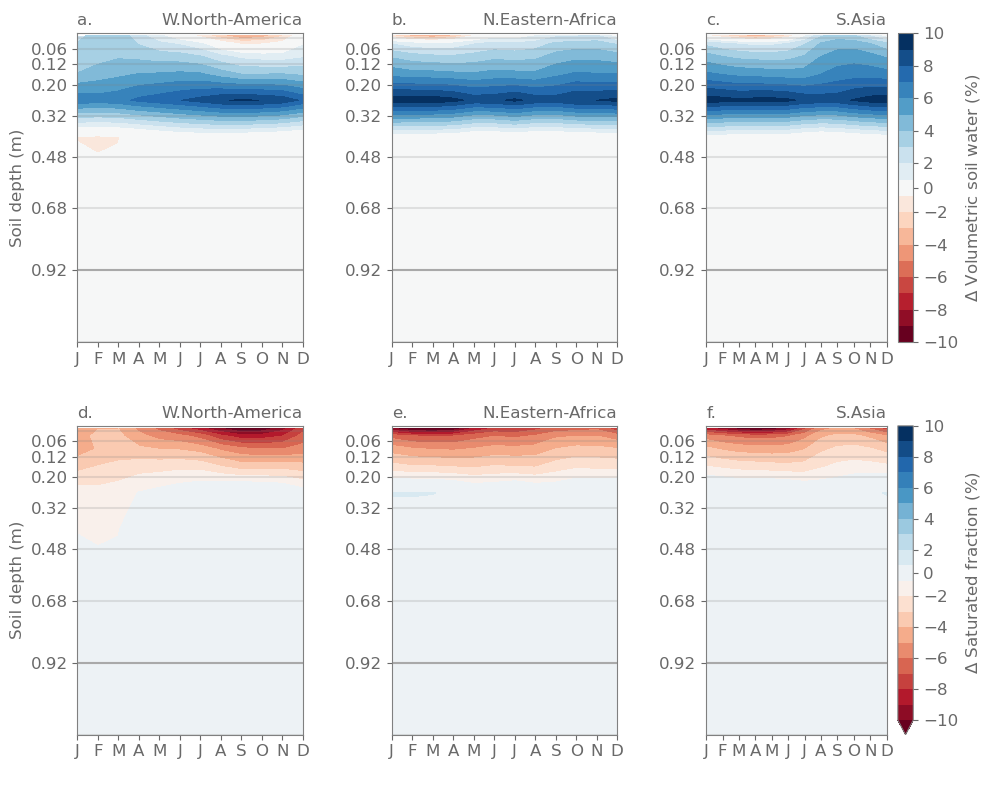

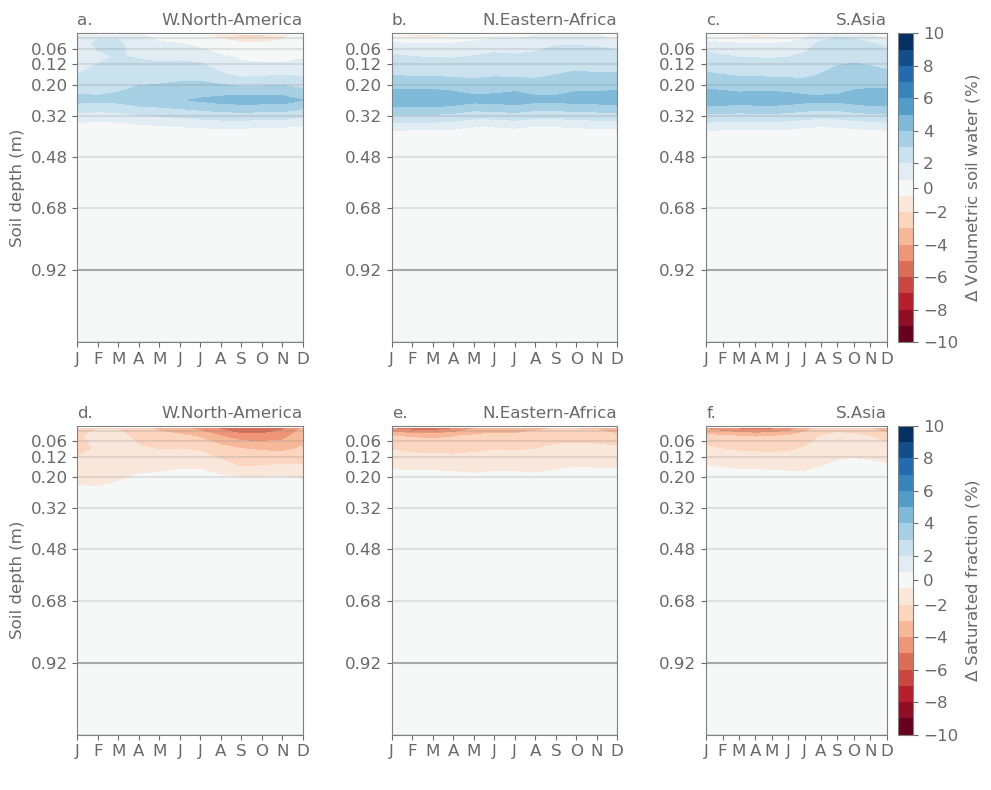

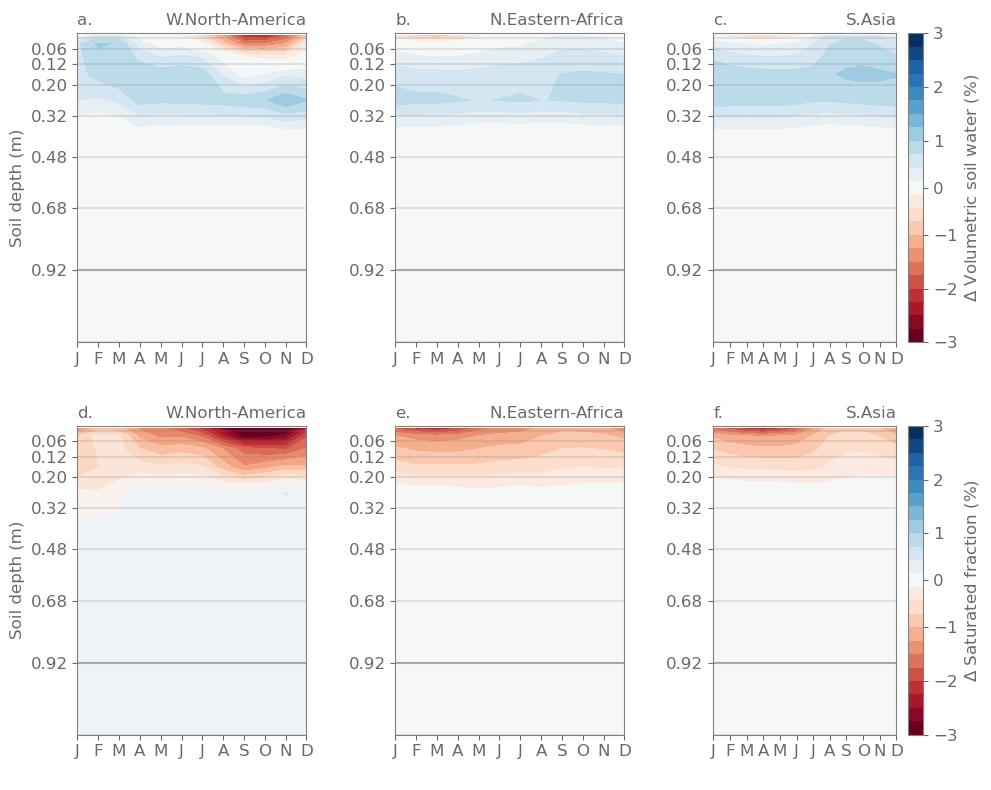

In [82]:
flag_calc_regionmeans = False

scenarios = ['high','medium',  '4p1000']

# define scenario
for scenario in scenarios: 
    
    case_scen = 'IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.'+scenario+'.spunup5'
    
    # crop list
    pft_list = [pft_list_crops[0]]


    if flag_calc_regionmeans: 
        save_regionalmean_delta_and_delta_rel('H2OSOI', pft_list, case_ctl, case_scen, region_ids, mask_regions, scenario)
        save_regionalmean_delta_and_delta_rel('satfrac', pft_list, case_ctl, case_scen, region_ids, mask_regions, scenario)

    # do plotting
    pft_int = pft_list_crops[0]

    # prepare for plotting 
    variable = 'H2OSOI'
    # open regions dataset
    da_regions = xr.open_dataset(procdir+'/postprocessing/pft_gridding/regional_means.'+variable+'.'+str(pft_int)+'.'+scenario+'.delta_change_rel.nc')[variable]

    da_regions_seasmean = da_regions.groupby('time.month').mean().squeeze()


    figsize = (10,8)
    fig, axes = plt.subplots(2,3,figsize=figsize)
    axes = axes.flatten()

    for i, region in enumerate(region_ids_sel):

        ax = axes[i]

        region_name = regionmask.defined_regions.ar6.land[region].name
        region_abbrev = regionmask.defined_regions.ar6.land[region].abbrev
        if scenario == 'high':  
            levels = np.arange(-10,11,1)
            ticks  = np.arange(-10,11,2)
        elif scenario == 'medium':  
            levels = np.arange(-10,11,1)
            ticks  = np.arange(-10,11,2)
        elif scenario =='4p1000': 
            levels = np.arange(-3,3.25,0.25)
            ticks  = np.arange(-3,3.5,1)

        levels = np.concatenate((levels[:int((len(levels)-1)/2)], levels[int((len(levels)-1)/2)+1:]))

            # with colorbar
        if i == len(region_ids_sel)-1: 
            da_regions_seasmean.sel(region=region).plot.contourf(ax=ax, x='month', y='levsoi', cmap='RdBu', cbar_kwargs={'label':'$\Delta$ Volumetric soil water (%)', 'ticks':ticks}, levels= levels)
        # without colorbar
        else: 
            da_regions_seasmean.sel(region=region).plot.contourf(ax=ax, x='month', y='levsoi', cmap='RdBu', levels= levels, add_colorbar=False)

        ax.hlines(levsoi_depth, 1,12, color='grey', alpha=0.2)
        ax.hlines(levsoi_depth[7],1,12, color='darkgrey', alpha=1)

        ax.set_yticks(np.array(levsoi_depth)[np.array(levsoi_depth) < plotting_depth][1:])
        ax.set_ylim([plotting_depth,0])
        ax.set_title(region_name, loc='right', size=12)
        ax.set_title(' ', loc='center')
        ax.set_title(labels[i], loc='left', size=12)
        ax.set_xlabel(' ')
        ax.set_ylabel('Soil depth (m)')
        ax.set_xticks(np.arange(1,13))
        ax.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])

        if i==0:
            ax.set_ylabel('Soil depth (m)')
        else: 
            ax.set_ylabel(' ')
    da_regions_seasmean.drop_vars(['ivt_str']).to_dataset(name=da_regions_seasmean.name).to_netcdf(datadir+'delta_rel_volumetricwater_seasonal_depth_profiles_per_region_'+scenario+'-CTL.nc')


    # prepare for plotting 
    variable = 'satfrac'
    # open regions dataset
    da_regions = xr.open_dataset(procdir+'/postprocessing/pft_gridding/regional_means.'+variable+'.'+str(pft_int)+'.'+scenario+'.delta_change_rel.nc')[variable]

    da_regions_seasmean = da_regions.groupby('time.month').mean().squeeze()


    for j, region in enumerate(region_ids_sel):

        ax = axes[i+1+j]

        region_name = regionmask.defined_regions.ar6.land[region].name
        region_abbrev = regionmask.defined_regions.ar6.land[region].abbrev
        
        if scenario == 'high':  
            levels = np.arange(-10,11,1)
            ticks  = np.arange(-10,11,2)
        elif scenario == 'medium':  
            levels = np.arange(-10,11,1)
            ticks  = np.arange(-10,11,2)
        elif scenario =='4p1000': 
            levels = np.arange(-3,3.25,0.25)
            ticks  = np.arange(-3,3.5,1)
            
        levels = np.concatenate((levels[:int((len(levels)-1)/2)], levels[int((len(levels)-1)/2)+1:]))

        # with colorbar
        if j == len(region_ids_sel)-1: 
            da_regions_seasmean.sel(region=region).plot.contourf(ax=ax, x='month', y='levsoi', cmap='RdBu', cbar_kwargs={'label':'$\Delta$ Saturated fraction (%)', 'ticks':ticks}, levels= levels)
        # without colorbar
        else: 
            da_regions_seasmean.sel(region=region).plot.contourf(ax=ax, x='month', y='levsoi', cmap='RdBu', levels= levels, add_colorbar=False)


        ax.hlines(levsoi_depth, 1,12, color='grey', alpha=0.2)
        ax.hlines(levsoi_depth[7],1,12, color='darkgrey', alpha=1)

        ax.set_yticks(np.array(levsoi_depth)[np.array(levsoi_depth) < plotting_depth][1:])

        ax.set_ylim([plotting_depth,0])
        ax.set_title(region_name, loc='right', size=12)
        ax.set_title(' ', loc='center')
        ax.set_xlabel(' ')
        ax.set_title(labels[i+1+j], loc='left', size=12)

        ax.set_xticks(np.arange(1,13))
        ax.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])

        if j==0:
            ax.set_ylabel('Soil depth (m)')
        else: 
            ax.set_ylabel(' ')

    da_regions_seasmean.drop_vars(['ivt_str']).to_dataset(name=da_regions_seasmean.name).to_netcdf(datadir+'delta_rel_saturatedfraction_seasonal_depth_profiles_per_region_'+scenario+'-CTL.nc', encoding={da_regions_seasmean.name: {"_FillValue": None}})

    fig.tight_layout()
    fig.savefig(figdir+'soil_profiles_'+scenario+'_rel.png', bbox_inches='tight')

## NOT USED

### Soil resistance sensitivity

FileNotFoundError: [Errno 2] No such file or directory: b'/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/innev/4p1000/processing_4p1000/postprocessing/pft_gridding/QSOIL_15.IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.CTL.spunup2.nc'

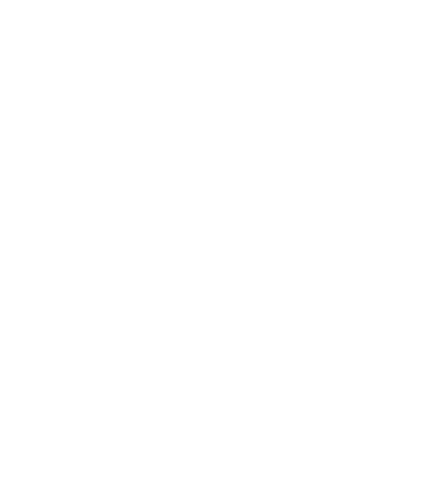

In [ ]:
variable = "QSOIL"
scenario = '4p1000'


# define scenario
case_ctl = 'IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.CTL.spunup2'
case_scen = 'IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.'+scenario+'.spunup2'

pft_int = pft_list_crops[0]
# make plot with all WB terms
fig, axes = plt.subplots(2,1, figsize = (8,6) ,subplot_kw={'projection': proj, 'frameon':False})
axes = axes.flatten()

cmap='BrBG'


da_pft_ctl = load_da_gridded_pft(variable, pft_int, case_ctl).rename(variable)

da_pft_scen = load_da_gridded_pft(variable, pft_int, case_scen).rename(variable)

da_pft_ctl_conv = conv_hydrol_var(da_pft_ctl.to_dataset(), [variable])[variable]
da_pft_ctl_conv.attrs['long_name'] = da_pft_ctl.long_name

da_pft_scen_conv = conv_hydrol_var(da_pft_scen.to_dataset(),[variable])[variable]
da_pft_scen_conv.attrs['long_name'] = da_pft_scen.long_name


da_delta = (da_pft_scen_conv - da_pft_ctl_conv)

ax = axes[0]

label = labels[0]

vlims = d_vlims_scenario[scenario][variable]
nstep= d_nsteps_scenario[scenario]
levels = np.arange(vlims[0],vlims[1]+nstep, nstep)
levels = np.concatenate((levels[:int((len(levels)-1)/2)], levels[int((len(levels)-1)/2)+1:]))

nstep_ticks = nstep*4
ticks = np.arange(vlims[0],vlims[1]+nstep_ticks, nstep_ticks)
# calc delta
if variable in d_vlims_scenario[scenario].keys(): 
    if 'levsoi' in da_delta.dims: 
        da_delta = da_delta.weighted(da_delta['levsoi']).mean(dim='levsoi')
    elif 'levgrnd' in da_delta.dims: 

        da_delta = da_delta.weighted(da_delta['levgrnd']).mean(dim='levgrnd')

    da_delta.attrs = da_pft_ctl_conv.attrs

# plot
da_delta.mean('time').plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, vmin=vlims[0], vmax=vlims[1], extend='both',  cbar_kwargs={'label': da_delta.units, 'fraction': 0.02, 'pad': 0.04, 'ticks':ticks}, levels=levels, add_labels=False)


ax.set_title(d_title[variable], loc='right')
ax.set_title(label, loc='left')

ax.coastlines(color='dimgray', linewidth=0.5)
# exclude Antactica from plot
ax.set_extent([-180,180,-63,90], crs=ccrs.PlateCarree())

ax.axis('off')


# -----------------------------------------------------------------------------------------------
## constant soil res

case_ctl = 'IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.CTL.cstsoilres'
case_scen = 'IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.'+scenario+'.cstsoilres'
da_pft_ctl = load_da_gridded_pft(variable, pft_int, case_ctl).rename(variable)

da_pft_scen = load_da_gridded_pft(variable, pft_int, case_scen).rename(variable)

da_pft_ctl_conv = conv_hydrol_var(da_pft_ctl.to_dataset(), [variable])[variable]
da_pft_ctl_conv.attrs['long_name'] = da_pft_ctl.long_name

da_pft_scen_conv = conv_hydrol_var(da_pft_scen.to_dataset(),[variable])[variable]
da_pft_scen_conv.attrs['long_name'] = da_pft_scen.long_name


da_delta = (da_pft_scen_conv - da_pft_ctl_conv)

ax = axes[1]

label = labels[1]

vlims = d_vlims_scenario[scenario][variable]
nstep= d_nsteps_scenario[scenario]
levels = np.arange(vlims[0],vlims[1]+nstep, nstep)
levels = np.concatenate((levels[:int((len(levels)-1)/2)], levels[int((len(levels)-1)/2)+1:]))

nstep_ticks = nstep*4
ticks = np.arange(vlims[0],vlims[1]+nstep_ticks, nstep_ticks)
# calc delta
if variable in d_vlims_scenario[scenario].keys(): 
    if 'levsoi' in da_delta.dims: 
        da_delta = da_delta.weighted(da_delta['levsoi']).mean(dim='levsoi')
    elif 'levgrnd' in da_delta.dims: 

        da_delta = da_delta.weighted(da_delta['levgrnd']).mean(dim='levgrnd')

    da_delta.attrs = da_pft_ctl_conv.attrs

# plot
da_delta.mean('time').plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, vmin=vlims[0], vmax=vlims[1], extend='both',  cbar_kwargs={'label': da_delta.units, 'fraction': 0.02, 'pad': 0.04, 'ticks':ticks}, levels=levels, add_labels=False)

ax.set_title(d_title[variable]+' with r$_{soil}$ = 2000 s m$^{-1}$', loc='right')
ax.set_title(label, loc='left')

ax.coastlines(color='dimgray', linewidth=0.5)
# exclude Antactica from plot
ax.set_extent([-180,180,-63,90], crs=ccrs.PlateCarree())
ax.axis('off')

fig.tight_layout()
fig.savefig(figdir+'soil_evaporation_cstresistant.png', bbox_inches='tight')

### NOT USED - maps of individual WB terms

In [ ]:
variables_toplot = ["TOTSOILLIQ", "QINFL" , "QOVER", "QDRAI",'EFLX_LH_TOT', "QVEGE", "QVEGT","QSOIL"]

In [ ]:
# difference 

d_vlims = {"QDRAI"        : [-5e-3,5e-3], 
           "QINFL"         : [-5e-3,5e-3],
           "QOVER"         : [-5e-3,5e-3],
           "TOTSOILLIQ"    : [-5e-3,5e-3],
           "EFLX_LH_TOT"   : [-5e-3,5e-3],
           "QVEGT"         : [-5e-3,5e-3], 
           "QVEGE"         : [-5e-3,5e-3], 
           "QSOIL"         : [-5e-3,5e-3],
           "SOILWATER_10CM": [-4,4]}

In [ ]:
pft_int = pft_list_crops[0]

scenario = 'high'
case_scen = 'IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.'+scenario+'.spunup5'

for i, variable in enumerate(variables_toplot): 
   
    da_pft_ctl = load_da_gridded_pft(variable, pft_int, case_ctl).rename(variable)

    da_pft_scen = load_da_gridded_pft(variable, pft_int, case_scen).rename(variable)
    
    da_pft_ctl_conv = conv_hydrol_var(da_pft_ctl.to_dataset(), [variable])[variable]
    da_pft_ctl_conv.attrs['long_name'] = da_pft_ctl.long_name

    da_pft_scen_conv = conv_hydrol_var(da_pft_scen.to_dataset(),[variable])[variable]
    da_pft_scen_conv.attrs['long_name'] = da_pft_scen.long_name

    
    da_delta = da_pft_scen_conv - da_pft_ctl_conv
    calc_plot_delta_da(da_delta, da_pft_ctl_conv, variable, d_vlims)
    
    

FileNotFoundError: [Errno 2] No such file or directory: b'/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/innev/4p1000/processing_4p1000/postprocessing/pft_gridding/TOTSOILLIQ_15.IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.CTL.spunup5.nc'

### ADDED Barplots of WB terms

In [ ]:
# calculate and save the time mean for different pfts
def calc_timmean_pft(pft_list, variables, case_ctl, case_scen, stream, start_year, end_year):

    for i,variable in enumerate(variables): 

        filename_delta_timmean  = procdir+'postprocessing/timmean/'+variable+'.'+case_ctl+'_delta.pfts.'+stream+'.'+str(start_year)+"-"+str(end_year)+"_timmean.nc"
        filename_ctl_timmean = procdir+'postprocessing/timmean/'+variable+'.'+case_ctl+'.pfts'+'.'+stream+'.'+str(start_year)+"-"+str(end_year)+"_timmean.nc"

        if not os.path.exists(filename_delta_timmean) or not os.path.exists(filename_ctl_timmean): 

            print(variable)

            da_delta, da_delta_rel = calc_delta_and_rel_pft(case_ctl, case_scen, variable, pft_list)

            list_da_pft = []

            for pft_int in pft_list: 

                list_da_pft.append(load_da_gridded_pft(variable, pft_int, case_ctl).rename(variable))

            da_ctl = xr.concat(list_da_pft, dim='ivt_str').rename({'ivt_str':'pft'})
            da_ctl['pft'] = pft_list


            da_delta_timmean = da_delta.mean('time')
            da_ctl_timmean = da_ctl.mean('time')


            da_delta_timmean.to_dataset(name=variable).compute().to_netcdf(filename_delta_timmean)
            da_ctl_timmean.to_dataset(name=variable).compute().to_netcdf(filename_ctl_timmean)
        
        else: 

            da_delta_timmean = xr.open_dataset(filename_delta_timmean)[variable]
            da_ctl_timmean = xr.open_dataset(filename_ctl_timmean)[variable]

            
        if i ==0: 
            ds_delta_timmean = da_delta_timmean.to_dataset(name=variable)
            ds_ctl_timmean = da_ctl_timmean.to_dataset(name=variable)
        else: 
            ds_delta_timmean[variable] = da_delta_timmean
            ds_ctl_timmean[variable] = da_ctl_timmean

    return ds_delta_timmean, ds_ctl_timmean

In [ ]:
%%time 

# calculate absolute water balance terms, including a unit conversion
def calc_wb_terms_pft_abs(variables_wb, variables_wb_toplot, pft_list, case_ctl, case_scen, stream, start_year, end_year, texture_name=False, texture_mask=False, flag_calc_wb=True): 
    d_wbterms = {}
    if flag_calc_wb:
        
        d_wb_vars = {}

        # load time averaged WB terms, assign units and convert units
        ds_delta_timmean, ds_ctl_timmean = calc_timmean_pft(pft_list, variables_wb, case_ctl, case_scen,  stream, start_year, end_year)
        
        # load sample control file to get the right longnames and units
        ds_sample = import_case(case_ctl, myVars=variables, stream='h0', timeSlice=slice(str(start_year)+"-01-01", str(start_year)+"-02-01"))

        for variable in variables_wb: 
            ds_delta_timmean[variable].attrs['units'] = ds_sample[variable].units
            ds_ctl_timmean[variable].attrs['units'] = ds_sample[variable].units
            ds_delta_timmean[variable].attrs['long_name'] = ds_sample[variable].long_name
            ds_ctl_timmean[variable].attrs['long_name'] = ds_sample[variable].long_name
            
        ds_delta_timmean = conv_hydrol_var(ds_delta_timmean, variables_wb)
        

        # when available apply texture mask
        if  not isinstance(texture_mask, bool) : 
            ds_delta_timmean = ds_delta_timmean.where(texture_mask) 
            ds_ctl_timmean = ds_ctl_timmean.where(texture_mask) 
        else: 
            texture_name = ''


        for pft_int in pft_list: 
            for i,region in enumerate(region_ids):

                region_name = regionmask.defined_regions.ar6.land[region].name
                region_abbrev = regionmask.defined_regions.ar6.land[region].abbrev

                d_var_list = {}


                for variable,variable_toplot in zip(variables_wb,variables_wb_toplot): 

                    da_delta_timmean = ds_delta_timmean[variable]

                    mask = regionmask.defined_regions.ar6.land.mask(da_delta_timmean)

                    da_ctl_seasmean_region = float(da_delta_timmean.sel(pft=pft_int).where(mask==region).mean(dim=('lat','lon')).values)

                    d_var_list[variable_toplot]= da_ctl_seasmean_region

                d_wb_vars[str(region)] = pd.Series(d_var_list).to_frame(name=str(region))

                df_wbterms = pd.concat([v for k,v in d_wb_vars.items()],axis=1)
                df_wbterms.to_csv(procdir+'postprocessing/wbterm_delta_per_region_'+scenario+'_'+str(pft_int)+'.'+texture_name+'_absolute.nc')
            d_wbterms[pft_int] = df_wbterms
    else: 
        for pft_int in pft_list: 
            d_wbterms[pft_int] = pd.read_csv(procdir+'postprocessing/wbterm_delta_per_region_'+scenario+'_'+str(pft_int)+'.'+texture_name+'_absolute.nc', index_col=0)
    return d_wbterms


CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.06 µs


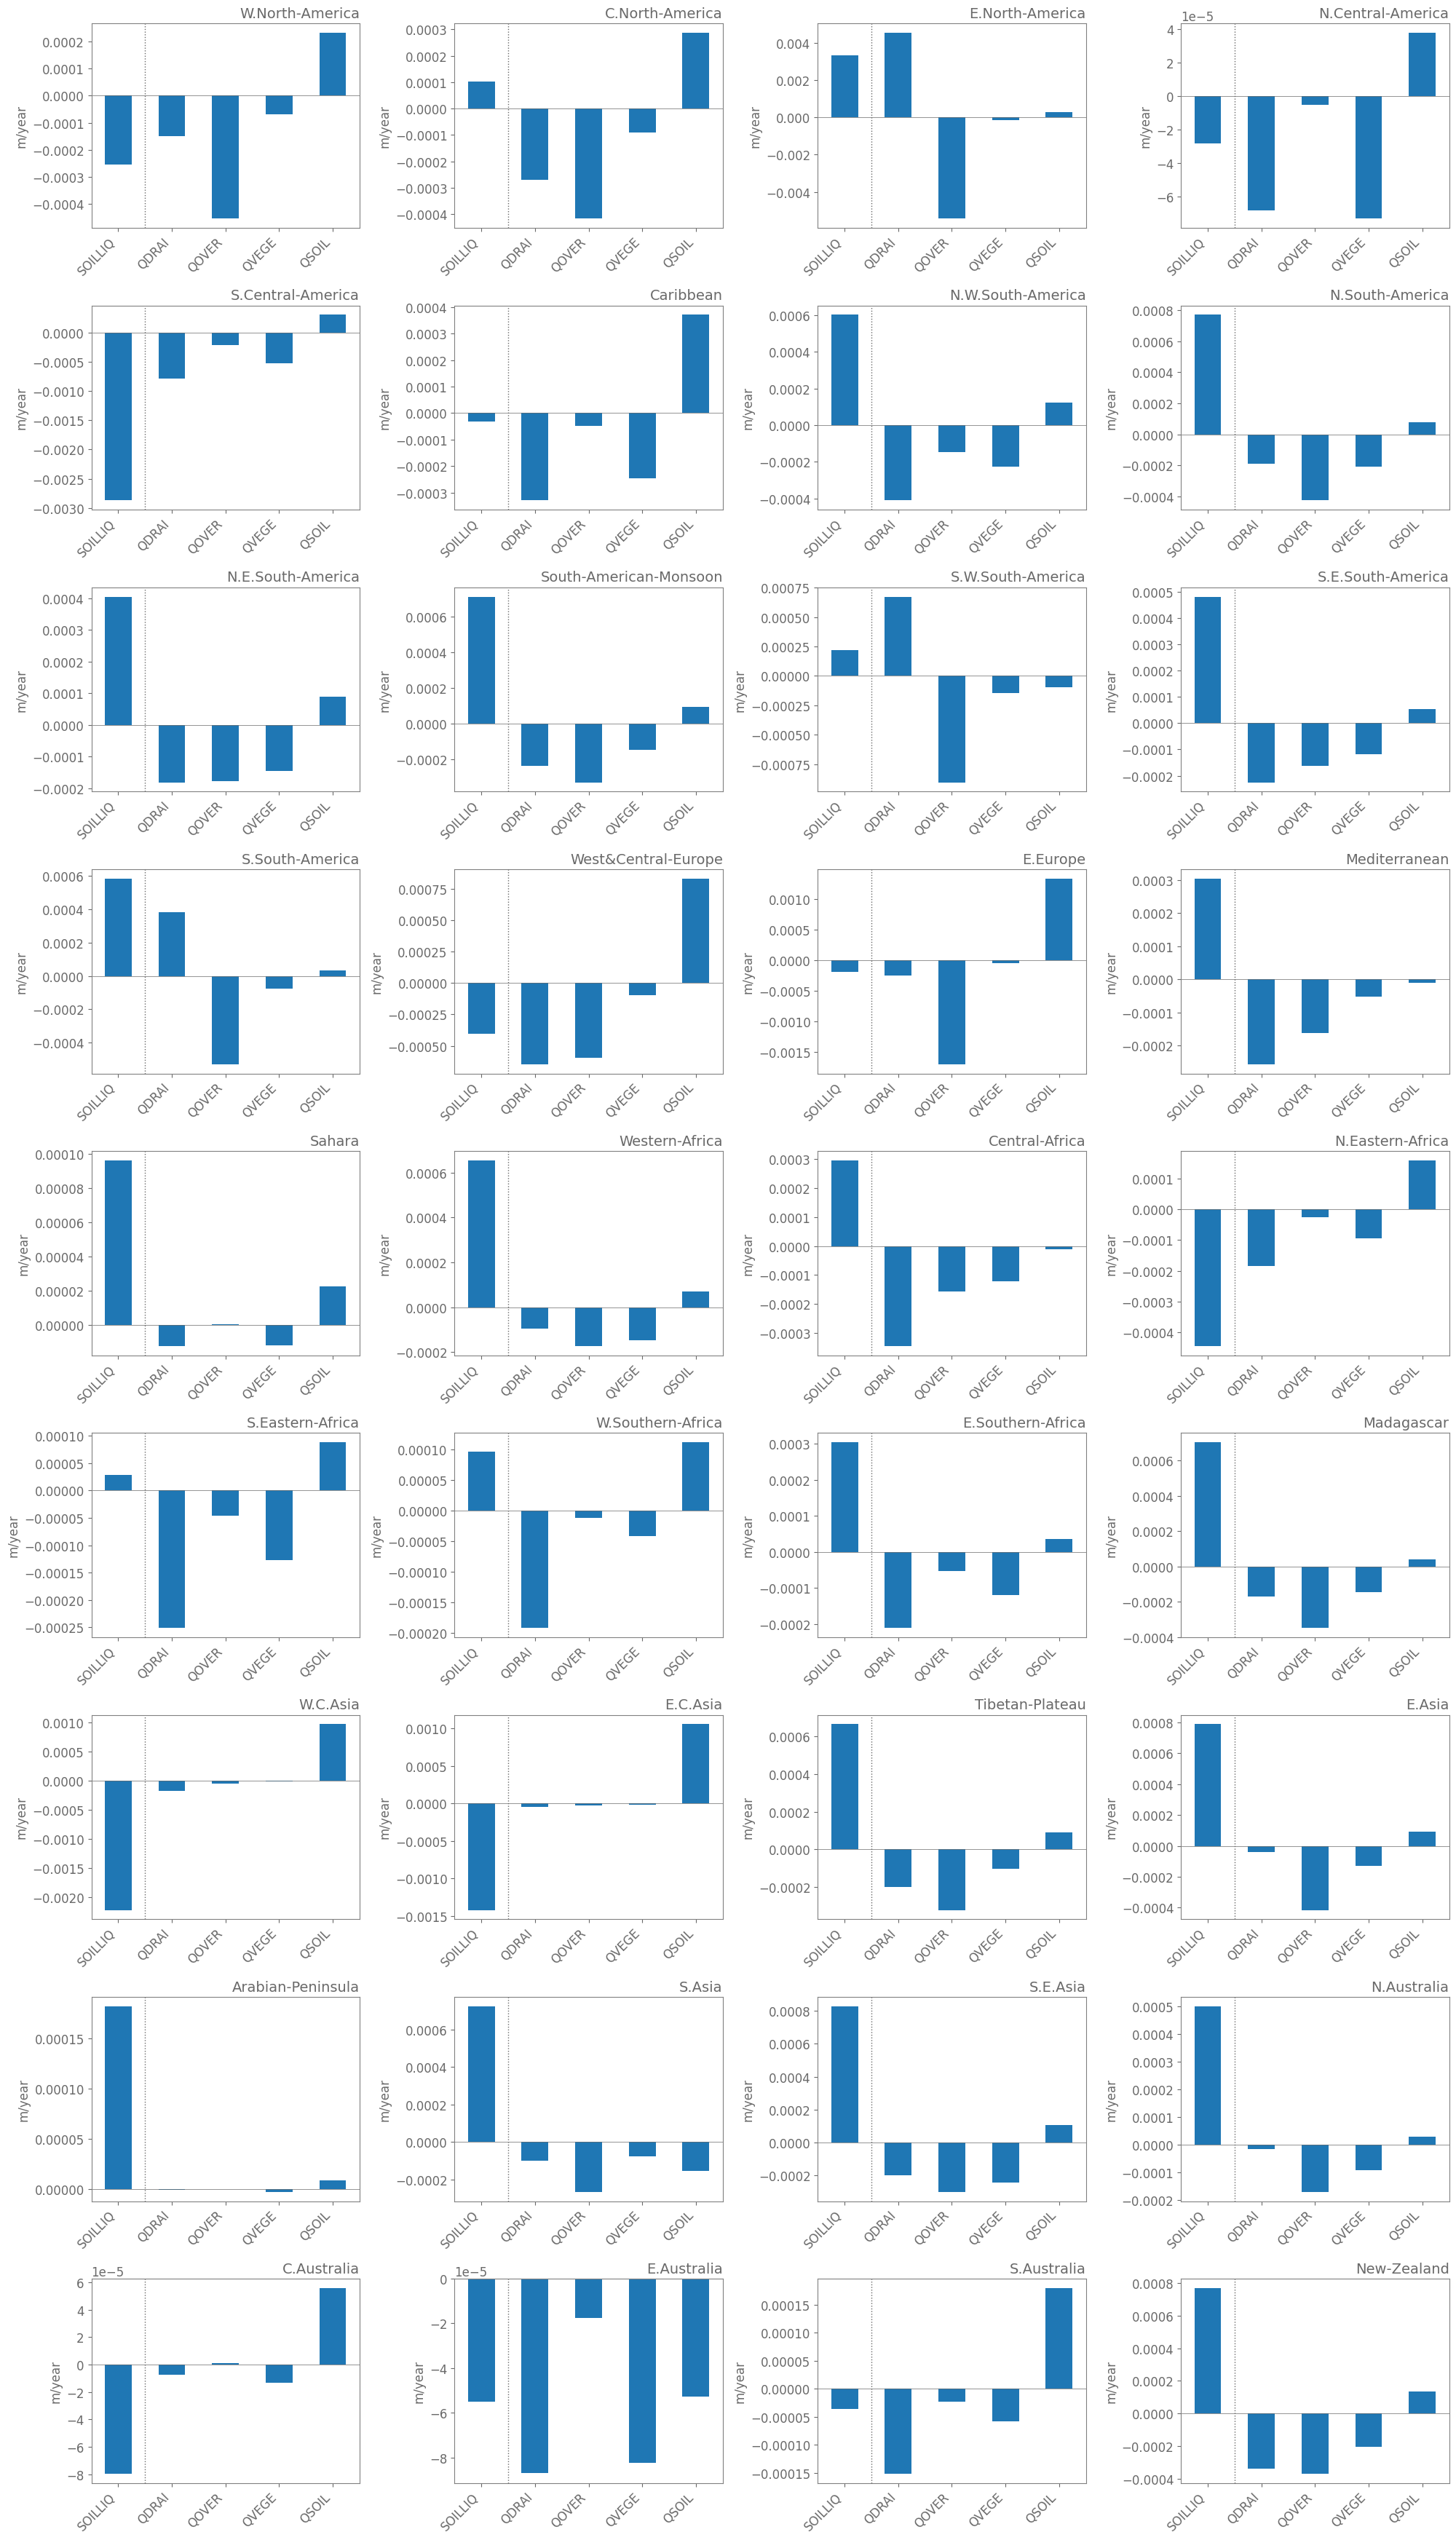

In [ ]:
pft_int = 15
pft_list = [15]
variables_wb        = ['TOTSOILLIQ', 'QDRAI' ,  'QOVER', "QVEGE", "QSOIL"]
variables_wb_toplot = ['SOILLIQ'   , 'QDRAI', 'QOVER',   "QVEGE", "QSOIL"]

scenario = 'high'
case_scen =    'IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.'+scenario+'.spunup5'


d_wbterms = calc_wb_terms_pft_abs(variables_wb, variables_wb_toplot, pft_list, case_ctl, case_scen, stream, start_year, end_year, flag_calc_wb=True)
df_wbterms = d_wbterms[pft_int]

figsize = (20,35)

fig, axes = plt.subplots(9,4,figsize=figsize)
axes = axes.flatten()



variables_wb = list(df_wbterms.index)
x = np.arange(1,len(variables_wb_toplot)+1,1)

for i,region in enumerate(region_ids):
    
    region_name = regionmask.defined_regions.ar6.land[region].name
    region_abbrev = regionmask.defined_regions.ar6.land[region].abbrev

    ax = axes[i]
    df_wbterms.loc[variables_wb_toplot, str(region)].plot.bar(ax=ax, legend=False)
    ax.set_title(region_name,loc='right')
    ax.axhline(y=0, color='dimgray', linewidth=0.5)
    ax.axvline(x=0.5, color='dimgray', linewidth=1, linestyle = 'dotted')
    #ax.axvline(x=1.5, color='dimgray', linewidth=1, linestyle = 'dotted')
    #ax.axvline(x=3.5, color='dimgray', linewidth=1, linestyle = 'dotted')

    ax.set_ylabel('m/year')

    ax.set_xticks(range(0,len(variables_wb_toplot)),list(variables_wb_toplot), rotation=45, ha='right')

fig.tight_layout()

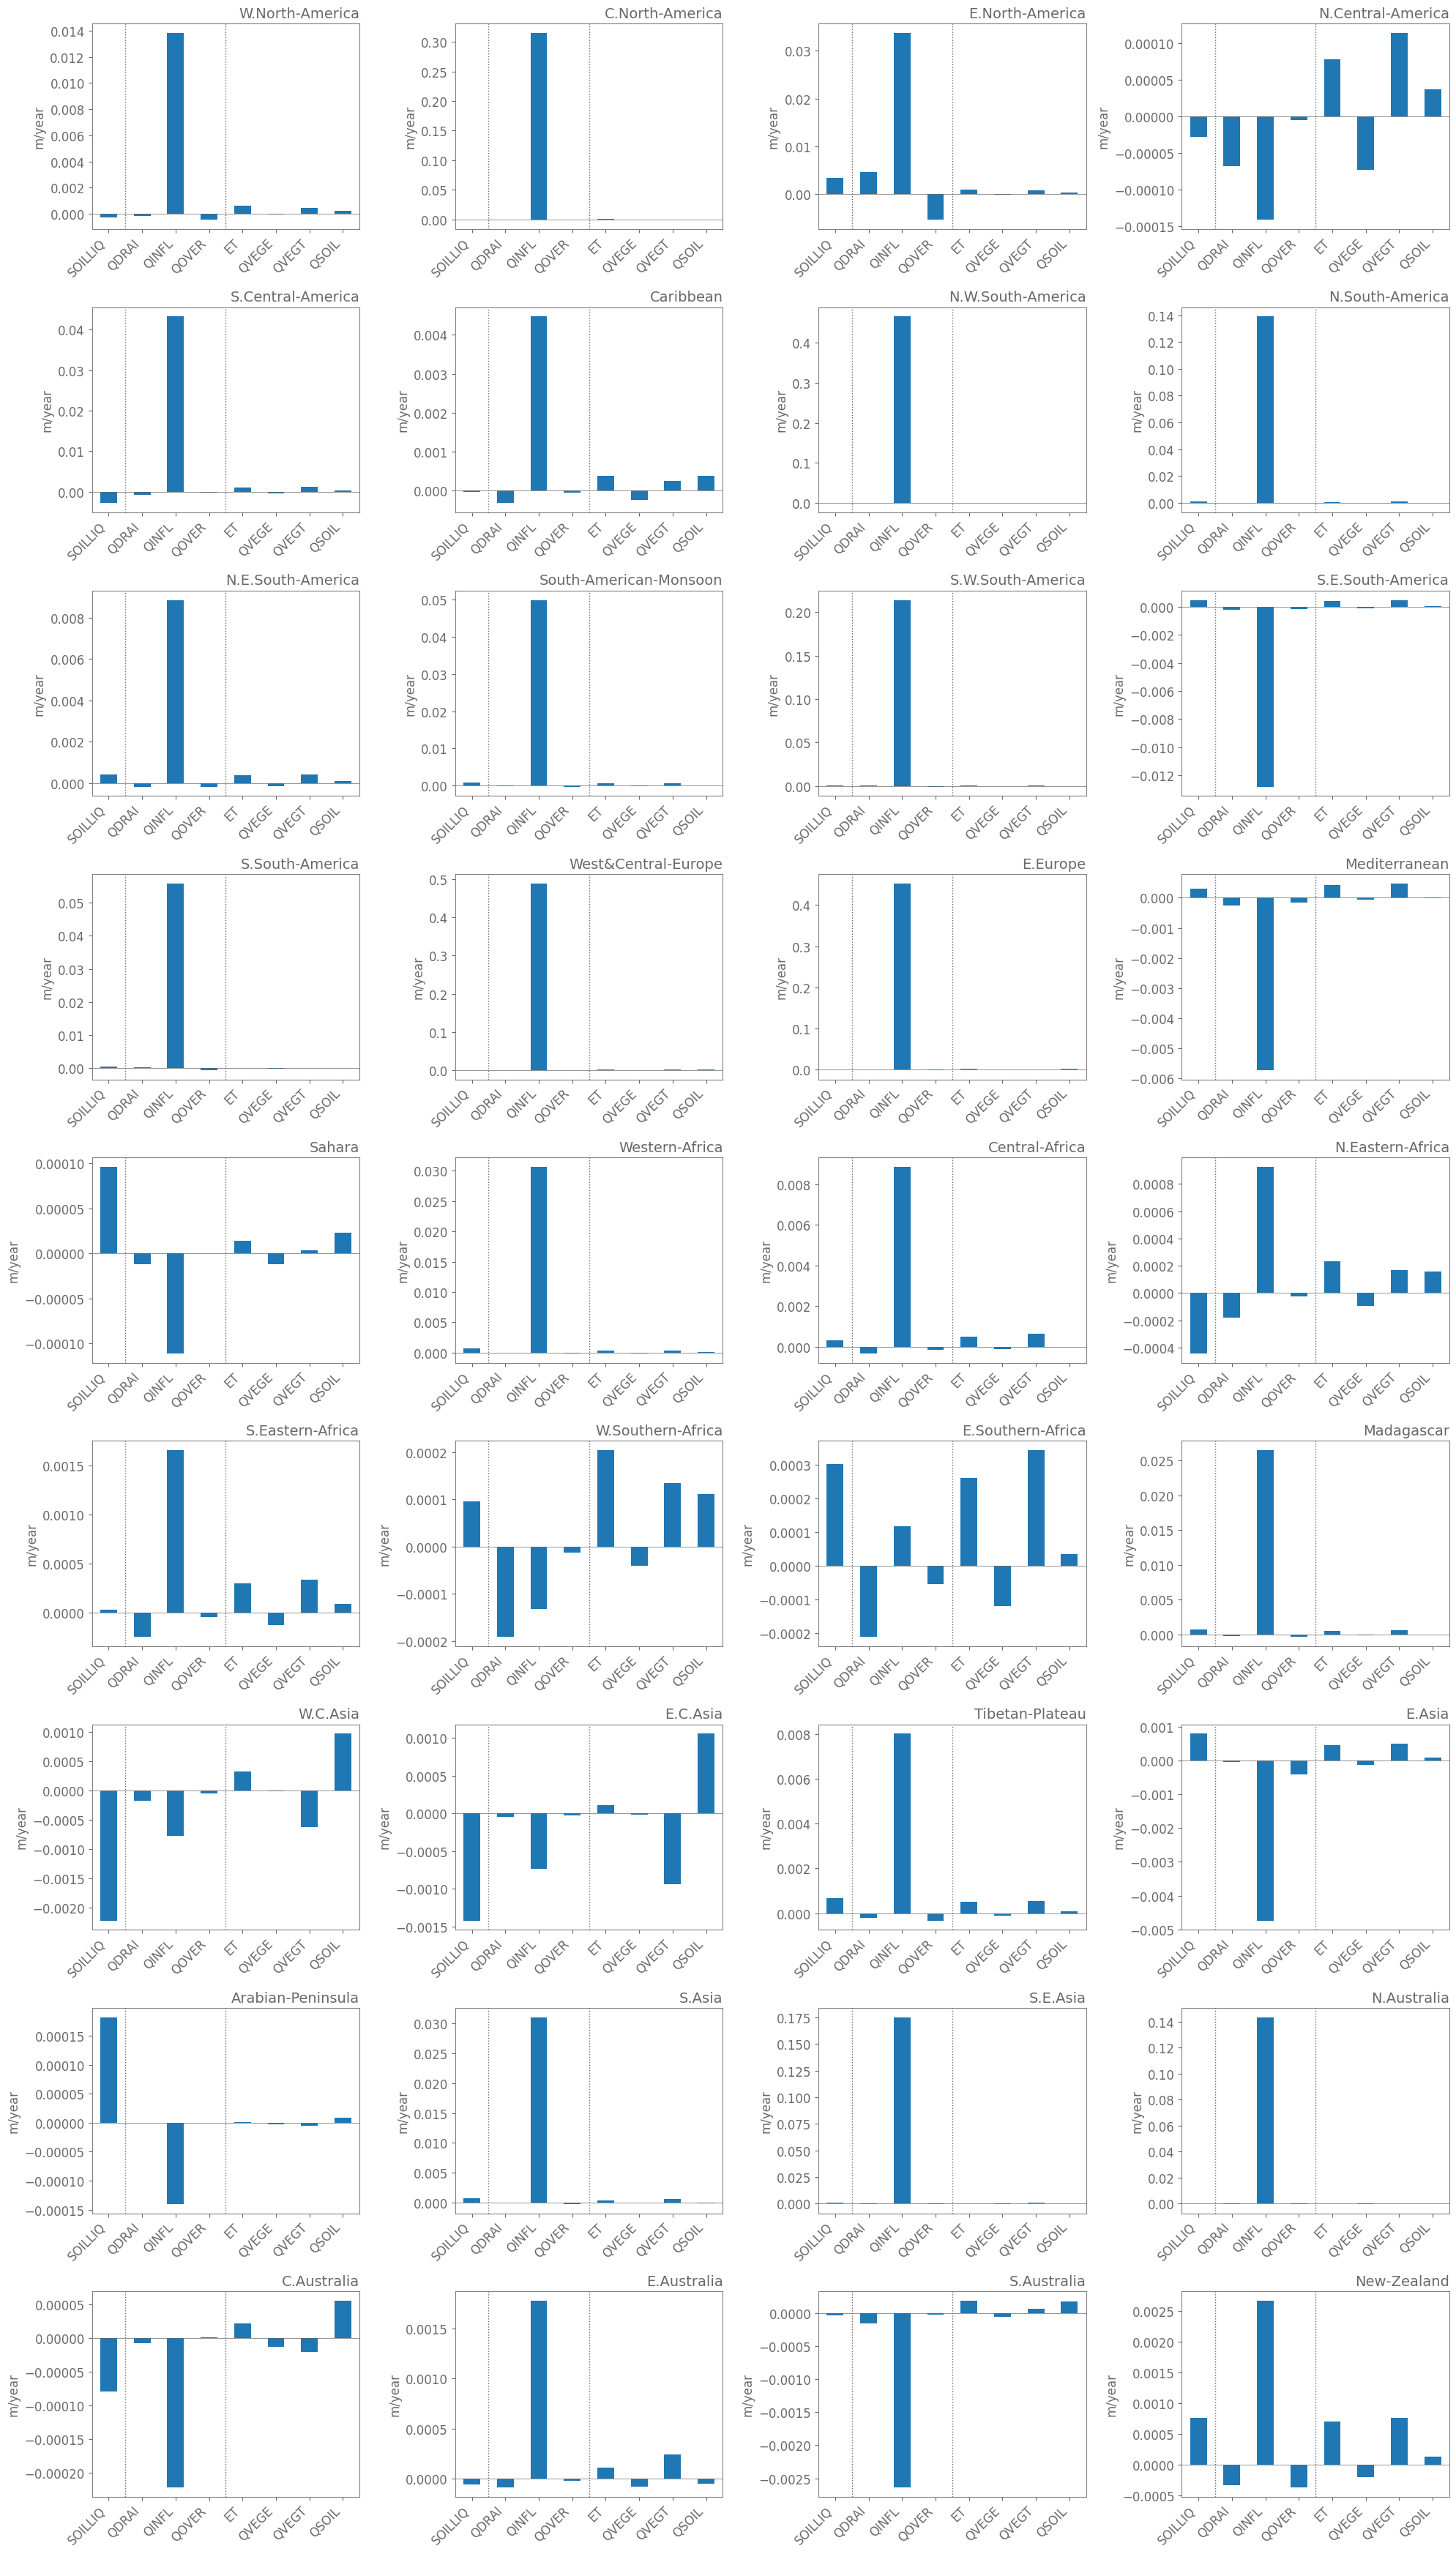

In [ ]:
pft_int = 15
pft_list = [15]
variables_wb        = ['TOTSOILLIQ','QDRAI' , 'QINFL', 'QOVER',  'EFLX_LH_TOT', "QVEGE", "QVEGT","QSOIL"]
variables_wb_toplot = ['SOILLIQ'   , 'QDRAI', 'QINFL', 'QOVER',     'ET'         , "QVEGE", "QVEGT","QSOIL"]

scenario = 'high'
case_scen =    'IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.'+scenario+'.spunup5'


d_wbterms = calc_wb_terms_pft_abs(variables_wb, variables_wb_toplot, pft_list, case_ctl, case_scen, stream, start_year, end_year, flag_calc_wb=True)
df_wbterms = d_wbterms[pft_int]

figsize = (20,35)

fig, axes = plt.subplots(9,4,figsize=figsize)
axes = axes.flatten()



variables_wb = list(df_wbterms.index)
x = np.arange(1,len(variables_wb_toplot)+1,1)

for i,region in enumerate(region_ids):
    
    region_name = regionmask.defined_regions.ar6.land[region].name
    region_abbrev = regionmask.defined_regions.ar6.land[region].abbrev

    ax = axes[i]
    df_wbterms.loc[variables_wb_toplot, str(region)].plot.bar(ax=ax, legend=False)
    ax.set_title(region_name,loc='right')
    ax.axhline(y=0, color='dimgray', linewidth=0.5)
    ax.axvline(x=0.5, color='dimgray', linewidth=1, linestyle = 'dotted')
    ax.axvline(x=1.5, color='dimgray', linewidth=1, linestyle = 'dotted')
    ax.axvline(x=.5, color='dimgray', linewidth=1, linestyle = 'dotted')

    ax.set_ylabel('m/year')

    ax.set_xticks(range(0,len(variables_wb_toplot)),list(variables_wb_toplot), rotation=45, ha='right')

fig.tight_layout()

### ADDED - maps of individual WB terms

### Plot QROOTSINK to see sign

In [ ]:
variables_toplot = ["QROOTSINK"]

In [21]:
# difference 

d_vlims = {"QDRAI"        : [-5e-3,5e-3], 
           "QINFL"         : [-5e-3,5e-3],
           "QOVER"         : [-5e-3,5e-3],
           "TOTSOILLIQ"    : [-5e-3,5e-3],
           "EFLX_LH_TOT"   : [-5e-3,5e-3],
           "QVEGT"         : [-5e-3,5e-3], 
           "QVEGE"         : [-5e-3,5e-3], 
           "QSOIL"         : [-5e-3,5e-3],
           "SOILWATER_10CM": [-4,4],
          "QROOTSINK": False}

In [ ]:
pft_int = pft_list_crops[0]

scenario = 'high'
case_scen = 'IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.'+scenario+'.spunup5'

for i, variable in enumerate(variables_toplot): 
   
    da_pft_ctl = load_da_gridded_pft(variable, pft_int, case_ctl).rename(variable)

    da_pft_scen = load_da_gridded_pft(variable, pft_int, case_scen).rename(variable)
    
    da_pft_ctl_conv = conv_hydrol_var(da_pft_ctl.to_dataset(), [variable])[variable]
    da_pft_ctl_conv.attrs['long_name'] = da_pft_ctl.long_name

    da_pft_scen_conv = conv_hydrol_var(da_pft_scen.to_dataset(),[variable])[variable]
    da_pft_scen_conv.attrs['long_name'] = da_pft_scen.long_name

    
    da_delta = da_pft_scen_conv - da_pft_ctl_conv
    calc_plot_delta_da(da_delta, da_pft_ctl_conv, variable, d_vlims)
    
    

OSError: [Errno -101] NetCDF: HDF error: '/project/s1207/ivanderk/scratch/processing_4p1000/postprocessing/pft_gridding/QROOTSINK_15.IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.CTL.spunup5.nc'

In [ ]:
## volumetric soil moisture, aggregating over different layers
levsoi_selections = [(0,19),  (0,5), (5,19)]

fig, axes = plt.subplots(3,1,figsize=(12,12),subplot_kw={'projection': proj, 'frameon':False})
da_delta_mean = da_delta.mean('time')
for n, levsoi_sel in enumerate(levsoi_selections): 

    ax = axes[n]
    label = labels[n]
    nstep = 0.001
    da_delta_mean = da_delta.isel(levsoi=range(levsoi_sel[0],levsoi_sel[1])).mean('time').sum('levsoi')
    # limiting values for plotting are given    
    da_delta_mean.where(landmask).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='BrBG',   extend='both',  vmax = 0.02, vmin = -0.02,cbar_kwargs={'label': da_delta.name+' (m)', 'fraction': 0.02, 'pad': 0.04}, add_labels=False)

    if n == 0 : 
        ax.set_title('$\Delta$ Root water uptake', loc='right')
    elif n == 1:
        ax.set_title('$\Delta$ Root water uptake above '+str(levsoi_depth[levsoi_sel[1]-1])+' m ', loc='right')

    elif n == 2: 
        ax.set_title('$\Delta$ Root water uptake below '+str(levsoi_depth[levsoi_sel[0]-1])+' m ', loc='right')

    ax.coastlines(color='dimgray', linewidth=0.5)
    ax.set_title(label, loc='left')

    # exclude Antactica from plot
    ax.set_extent([-180,180,-63,90], crs=ccrs.PlateCarree())
    ax.axis('off')

